In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
# block to setup BQ
import os
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project='wx-bq-poc',)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# build comparison code
* compare normalised prob
* compare inc sales (default to email as well as others)

In [3]:
def convert_to_post_MTA_format(fpath_results,
                               campaign_code,
                               fw,
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final`",
                               rm_fb=True,
                               create_dacamp_prod_mc_final=False):
    """
    Overview
        Convert output from MTA package into post MC format in Safari (for downstream processing to MC CRN level).
        Saves to BQ.
    Arguments
        fpath_results - filepath to CSV with channel attribution, MTA package output
        campaign_code - e.g. "CVM-1661"
        fw - financial week, e.g. "2021-04-12"
        dacamp_prod_mc_final - where to save MC attribution in post MTA format, BQ table
    Returns
        table saved to BQ
    """
    df = pd.read_csv(fpath_results)
    
    print("\tremoving facebook touchpoints from MC output")
    if rm_fb:  # rm fb touchpoints and rescale everything back up to 100%
        conversion_value_fb = df.loc[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression"), "normalised_conversion_value"].sum()
        conversion_value_non_fb = df.loc[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression"), "normalised_conversion_value"].sum()
        scaling = 1 / conversion_value_non_fb
        df.loc[:, "normalised_conversion_value"] = scaling * df.loc[:, "normalised_conversion_value"]
        df = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")]

    
    df = df.drop("Unnamed: 0", axis="columns")

    df.loc[:, "event"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 0]
    df.loc[:, "campaign_start_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 1]
    df.loc[:, "campaign_end_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 2]

    # extract channel, medium, event from full MC node name
    event_extract = df.channel_name.str.extract(r"({campaign_code}|_AlwaysOn)_(display|email|rw_app|google_other|sem|wow_web)(_brand|_generic|_other|_shopping)?_(clk|open|imp|view)".format(campaign_code=campaign_code)).fillna("")
    event_extract

    df.loc[:, "channel"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1]
    df.loc[:, "medium"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1] + event_extract.iloc[:, 2]
   
    df.loc[:, "key"] = "Total_supermarkets_" + campaign_code + "_" + df.loc[:, "campaign_start_date"] + '_' + df.loc[:, "campaign_end_date"]
    df.loc[:, "banner"] = "supermarkets"
    df.loc[:, "campaign_code"] = campaign_code
    df = df.rename({"normalised_conversion_value":"channel_prob_norm"}, axis="columns")
    
#     return df
    # check extraction went OK
    if df.isnull().sum().sum() != 0:
        print("ERROR: input dataframe has NANs... exiting")
        print(df)
        return df
    assert df.isnull().sum().sum() == 0
    
    print("\tdf generated for upload to BQ")

    # dump to BQ for downstream processing (convert to CRN level)
    df.to_gbq('personal.AL_FBAA_MC_mc_final_tmp', project_id='wx-bq-poc', if_exists='replace')
    
    if create_dacamp_prod_mc_final:
        comment_out = "#"
    else:
        comment_out = ""

    query_string = """
    -- generating dummy table
    create or replace table {dacamp_prod_mc_final} as
    
    {comment_out}select * from `wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_{fw}` where campaign_code != "{campaign_code}";    
    {comment_out}INSERT INTO {dacamp_prod_mc_final}    
    
    select 
      key,
      banner,
      campaign_code,
      campaign_start_date,
      campaign_end_date,
      channel,
      medium,
      event,
      -1 as event_volume,
      -1 as event_reach,
      -1 as event_converted_crn,
      -1 as medium_reach,
      -1 as medium_converted_crn,
      channel_prob_norm
    from `wx-bq-poc.personal.AL_FBAA_MC_mc_final_tmp` where channel_prob_norm > 0;

    -- show header to check if it worked
    select * from {dacamp_prod_mc_final} where campaign_code = '{campaign_code}' limit 50;
    """.format(campaign_code=campaign_code, fw=fw, dacamp_prod_mc_final=dacamp_prod_mc_final, comment_out=comment_out)
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print("\tpost MTA output uploaded to BQ")
    return df_bq


In [4]:
def run_post_MTA_processing(dacamp_prod_event_mw, dacamp_prod_activation, dacamp_prod_online_sales, marketable_crn,
                            dacamp_prod_mc_final, dacamp_prod_mc_final_crn):
    """
    Overview
        Runs Shanglin's post MTA processing (create CRN level attribution, further adjustments)
        Based on:
        https://bitbucket.org/wx_rds/safari-prod/src/master/markov_chain/bq_query/mc/mc_camp_mcfinal_crn_base.sql
    Arguments
        dacamp_prod_event_mw - copy of Shanglin's events, a BQ table
        dacamp_prod_activation - copy of Shanglin's activations, a BQ table
        dacamp_prod_online_sales - copy of Shanglin's online activations, a BQ table
        marketable_crn - copy of marketable CRNs, a BQ table
        dacamp_prod_mc_final - post MTA output (e.g. this is the MC input to the post MTA process), a BQ table
        dacamp_prod_mc_final_crn - BQ table to save the CRN level (output of this process)
    Returns
        An empty DF if successful
    """
    query_string = """
    ------------------------------------------------------
    -- REPLICATE SHANGLINS POST MTA CODE
    ------------------------------------------------------
    drop table if exists {dacamp_prod_mc_final_crn};
    create table {dacamp_prod_mc_final_crn} as
    (
        with onl_start_date as 
        (	
            select max(campaign_start_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        ),

        onl_end_date as 
        (
            select max(campaign_end_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        )

        SELECT distinct DATE_TRUNC(DATE_ADD((select * from onl_end_date),interval 0 day), week(Monday)) as week
            , c.crn
            , e.segment_cvm
            , e.segment_lifestage
            , f.segment_marketable
            , c.banner
            , c.campaign_code
            , c.campaign_type
            , c.campaign_start_date
            , c.campaign_end_date
            , c.tot_spend as total_sales
            , c.spend as inc_sales
            , channel_event
            , channel_prob_norm
            , case when a.channel is not null then a.channel else d.channel end as channel
            , case when a.medium is not null then a.medium else d.medium end as medium
            , case when a.event is not null then a.event else d.event end as event
            , case when channel_prob_norm is not null then channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when channel_prob_norm is null and channel_event is not null then 0 
                    else 1 end as attributed_conversion
            , case when channel_prob_norm is not null then c.tot_spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when  channel_prob_norm is null and channel_event is not null then 0 
                    else c.tot_spend end as attributed_total_sales
            , case when channel_prob_norm is not null then c.spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    WHEN channel_prob_norm is null and channel_event is not null then 0 
                     else c.spend end as attributed_inc_sales
        FROM
        (
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , banner
                , crn
                , campaign_code
                , campaign_start_date
                , campaign_end_date
                , campaign_end_date_real
                , campaign_type
                , case when sum(tot_spend) is null then 0 else sum(tot_spend) end as tot_spend
                , case when sum(spend) is null then 0 else sum(spend) end as spend
            FROM
            (
                SELECT crn
                    , banner
                    , campaign_code
                    , campaign_start_date
                    , campaign_end_date
                    , campaign_end_date_real
                    , campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as spend
                FROM {dacamp_prod_activation}
                group by 1,2,3,4,5,6,7

                union all

                SELECT crn
                    , 'supermarkets' as banner
                    , 'ONLINE' as campaign_code
                    , (select * from onl_start_date) as campaign_start_date
                    , (select * from onl_end_date) as campaign_end_date
                    , (select * from onl_end_date) as campaign_end_date_real
                    , 'ONLINE' as campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as tot_spend
                FROM {dacamp_prod_online_sales}
                group by 1
            )
            group by 1,2,3,4,5,6,7,8
        ) c 

        left join
        (		
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , crn 
                , channel_event 
                , count(*) as event_volume
            FROM {dacamp_prod_event_mw} 
            group by 1,2,3
            order by 1,2,3
        ) b on b.key = c.key and b.crn = c.crn

        left join 
        (
            select *
        from {dacamp_prod_mc_final}
        ) a on a.key = b.key and a.event = b.channel_event 

        left join
        (
            SELECT a1.key
            , CASE WHEN channel is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN channel is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else channel end as channel
            , CASE WHEN medium is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN medium is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else medium end as medium
            ,  CASE WHEN event is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email_open') 
                    WHEN event is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app_imp') 
                    else event end as event
            , event_volume
            , event_reach
            , event_converted_crn
            , medium_reach
            , medium_converted_crn
            FROM
            (
                select distinct key, campaign_code
          from {dacamp_prod_mc_final}
            ) a1
            left join
            (	SELECT key
                    , channel
                    , medium
                    , event
                    , event_volume
                    , event_reach
                    , event_converted_crn
                    , medium_reach
                    , medium_converted_crn
          from {dacamp_prod_mc_final}
                where (campaign_code = 'ONLINE' and event like '%wow_web_view%')
                    or (campaign_code like '%NM%' and regexp_contains(event, r'(?i)rw_app_imp') and substr(event,1,9) = substr(campaign_code,1,9))
            or (campaign_code not like '%NM%' and campaign_code <> 'ONLINE' and regexp_contains(event, r'(?i)email_open') and substr(event,1,9) = substr(campaign_code,1,9))
            ) a2 on a1.key = a2.key
        ) d on c.key = d.key

        left join
        (
            SELECT crn, max(macro_segment_curr) as segment_cvm, max(lifestage) as segment_lifestage
            FROM `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`
            where Date(pw_end_date_utc) = (select max(Date(pw_end_date_utc)) from `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`)
            group by 1
        ) e on c.crn = e.crn

        left join
        (
            SELECT crn, max(marketable) as segment_marketable
            FROM {marketable_crn}
            group by 1
        ) f on c.crn = f.crn

    );
    """.format(dacamp_prod_event_mw=dacamp_prod_event_mw,
               dacamp_prod_activation=dacamp_prod_activation,
               dacamp_prod_online_sales=dacamp_prod_online_sales,
               marketable_crn=marketable_crn,
               dacamp_prod_mc_final=dacamp_prod_mc_final,
               dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn
              )
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    return df_bq

# run_post_MTA_processing(dacamp_prod_event_mw="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_event_mw_2021-04-12`",
#                         dacamp_prod_activation="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_activation_2021-04-12`",
#                         dacamp_prod_online_sales="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_online_sales_2021-04-12`",
#                         marketable_crn="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_marketable_crn_2021-04-12`",
                        
#                         # new MTA MC output   
#                         dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final`",         
#                         dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn`"                        
#                        )


In [5]:
def get_post_MTA_inc_sales(campaign_code, data_date, groupby="channel", fpath_out=None):
    """
    Overview
        Grabs the final Safari post-MTA results (including manual FBAA run) from GCP
    Arguments
        campaign_code
        data_date - date of MTA run, check gs://digital-attribution-data/phase2/markov_out/
        groupby="channel"
        fpath_out=None
    Returns
        Dataframe of grouped post-MTA results
    """
    df = pd.read_csv('gs://digital-attribution-data/phase2/markov_out/' + data_date + '/mc_final_agg.csv')
    mask = (df.campaign_code == campaign_code) & (df.segment == "Total")
    df_group = df[mask].groupby(groupby).sum()
    df_group['attributed_inc_sales_percent'] = (df_group['attributed_inc_sales'] / df_group['attributed_inc_sales'].sum()) * 100
    if fpath_out:
        df_group.to_csv(fpath_out + "post_MTA_results_" + data_date + ".csv")
    return df_group

In [6]:
def compare_MTA_results(dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old, campaign_code, safari_run_date,
                       fpath_out, fw):
    """
    Overview
        Compares CRN level post MTA results of the old and new method.
    Arguments
        dacamp_prod_mc_final_crn_new
        dacamp_prod_mc_final_crn_old
        campaign_code
        safari_run_date
    Returns
        Dataframe of comparison results (old vs. new method)
    """
    query_string = """
    -- new MTA results vs old
    with results_AL as (  -- new results
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales
    FROM {dacamp_prod_mc_final_crn_new}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    ),
    results_Shanglin as (
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales
    FROM {dacamp_prod_mc_final_crn_old}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    )
    select
      coalesce(a.campaign_code, b.campaign_code) as campaign_code,
      coalesce(a.campaign_start_date, b.campaign_start_date) as campaign_start_date,
      coalesce(a.channel, b.channel) as channel,
      coalesce(a.medium, b.medium) as medium,
      coalesce(a.event, b.event) as event,
      coalesce(a.channel_event, b.channel_event) as channel_event,
      a.channel_prob_norm as channel_prob_norm_AL,
      b.channel_prob_norm as channel_prob_norm_shanglin,
      a.attributed_inc_sales as attributed_inc_sales_AL,
      b.attributed_inc_sales as attributed_inc_sales_shanglin
    from results_AL as a
    full outer join results_Shanglin as b
      on a.event = b.event and a.channel_event = b.channel_event and a.campaign_start_date = b.campaign_start_date
    order by coalesce(a.campaign_start_date, b.campaign_start_date), coalesce(a.event, b.event), coalesce(a.channel_event, b.channel_event)
    ;
    """.format(dacamp_prod_mc_final_crn_new=dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old,
               campaign_code=campaign_code)

    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    
    results.loc[:, "channel"] = results.channel.str.strip("_")
    results.loc[:, "medium"] = results.medium.str.strip("_")
    results.loc[:, "event"] = results.event.str.strip("_")
    
    plt.title("MTA results current vs new")
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results)
    plt.savefig(fpath_out + "_comp_scatter_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.title("MTA results current vs new (excluding default channel)")
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results[results.channel_event != "DEFAULT"])    
    plt.savefig(fpath_out + "_comp_scatter_ex_def_channel_" + campaign_code + "_" + fw +  ".png")
    plt.show()
    
    # pull in final results from Safari, saved to GCP    
    results_comparison = pd.merge(left=results.groupby("event").sum(), right=get_post_MTA_inc_sales(campaign_code, safari_run_date, groupby="event"),
                                  how="outer", on="event").loc[:, ['channel_prob_norm_AL', 'channel_prob_norm_shanglin', 'attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales']]
    results_comparison = results_comparison.rename({"attributed_inc_sales":"attributed_inc_sales_safari"}, axis="columns")
    
    plt.title("MTA results current Safari vs new (grouped)")
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_safari", data=results_comparison)
    plt.savefig(fpath_out + "_comp_scatter_grouped_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.subplots(figsize=(30, 15))
    plt.title("MTA results current vs new")
    sns.heatmap(results_comparison.loc[:, ['attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales_safari']], cmap='cividis', annot=True, fmt=".2f")
    plt.savefig(fpath_out + "_comp_heatmap_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    return results, results_comparison

In [8]:
# extract FB ratio
# campaign_code = "CVM-1661"
# campaign_start_date = "2021-02-15"
# campaign_end_date = "2021-02-21"
# fpath_results = "01_results/res_CVM-1661_2021-02-15_2021-02-21_7.csv"
# dacamp_prod_mc_final_crn_w_fb="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb`"
# dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn`"

def allocate_fb_inc_sales(campaign_code, campaign_start_date, campaign_end_date, fpath_results, dacamp_prod_mc_final_crn_w_fb,
                          dacamp_prod_mc_final_crn):
    # extract scaling factor from package results
    df = pd.read_csv(fpath_results)
    attr_fb = df[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression")].normalised_conversion_value.sum()
    attr_non_fb = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")].normalised_conversion_value.sum()
    fb_scaling = attr_fb / attr_non_fb

    print("\tFB scaling ratio is (for missing slice of pie)", fb_scaling)
    if fb_scaling > 1.5 or fb_scaling < 0.67:
        print("WARNING... FB scaling ratio is outside normal range of values")

    # allocating newly discovered slices of the pie at the CRN level on BQ
    query_string = """
      ---------------------------------------------------------------------------
      -- ADDING IN FB INC SALES
      ---------------------------------------------------------------------------
    CREATE OR REPLACE TABLE
      {dacamp_prod_mc_final_crn_w_fb} AS
    WITH
      unique_crn AS (  -- base to create more entries
      SELECT
        DISTINCT week,
        crn,
        segment_cvm,
        segment_lifestage,
        segment_marketable,
        banner,
        campaign_code,
        campaign_type,
      FROM
        {dacamp_prod_mc_final_crn}
      WHERE
        campaign_code = "{campaign_code}"),
      total_inc_sales AS (
      SELECT
        SUM(attributed_inc_sales)
      FROM
        {dacamp_prod_mc_final_crn}
      WHERE
        campaign_code = "{campaign_code}" ),
      total_crn_count AS (
      SELECT
        COUNT(*)
      FROM
        unique_crn ),
      new_rows AS (
      SELECT
        unique_crn.week,
        unique_crn.crn,
        unique_crn.segment_cvm,
        unique_crn.segment_lifestage,
        unique_crn.segment_marketable,
        unique_crn.banner,
        unique_crn.campaign_code,
        unique_crn.campaign_type,
        PARSE_DATE('%Y-%m-%d',
          '{campaign_start_date}') AS campaign_start_date,
        PARSE_DATE('%Y-%m-%d',
          '{campaign_end_date}') AS campaign_end_date,
        0 AS total_sales,
        0 AS inc_sales,
        "" AS channel_event,
        -1 AS channel_prob_norm,
        '{campaign_code}_FB' AS channel,
        '{campaign_code}_FB' AS medium,
        '{campaign_code}_FB_impsclicks' AS event,
        0 AS attributed_conversion,
        0 AS attributed_total_sales,
        {fb_scaling} * (
        SELECT
          *
        FROM
          total_inc_sales) / (
        SELECT
          *
        FROM
          total_crn_count) AS attributed_inc_sales  -- uniformly allocate fb inc sales to each CRN
      FROM
        unique_crn)
    SELECT
      *
    FROM
      {dacamp_prod_mc_final_crn}
    UNION ALL
    SELECT
      *
    FROM
      new_rows;
      -- CHECKS
    SELECT
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn} where campaign_code = '{campaign_code}') as inc_sales_before_ws_only,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_before,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) as inc_sales_after,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_increase,
      (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_before,
      (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) as count_after,
      (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_increase
    ;
    """.format(dacamp_prod_mc_final_crn_w_fb=dacamp_prod_mc_final_crn_w_fb, dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn,
                   campaign_code=campaign_code, fb_scaling=fb_scaling, campaign_start_date=campaign_start_date,
              campaign_end_date=campaign_end_date)
    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

    # check increase went to plan
    fb_increase = results.inc_sales_increase.values[0] / results.inc_sales_before_ws_only.values[0]
    print("\tfb inc sales for", campaign_code, "increased by", fb_increase)
    assert abs(fb_increase - fb_scaling) < 0.0001
    print("\ttouchpoint count increased by", results.count_increase.values[0])
    assert results.count_increase.values[0] > 900_000 and results.count_increase.values[0] < 1_750_000
    
    return results

In [19]:
def run_downstream_process(fpath_results, campaign_code, fw, safari_run_date, fpath_comparison_results="01_results/",
                            BQ_output_suffix="", create_dacamp_prod_mc_final=False, have_historical_marketable_crn=True,
                            use_xueyuans_mc_crn_output=False,
                            allocate_fb=False):
    """
    Overview
        runs the entire post MC process and compares it to the current BAU runs
    Arguments
        fpath_results - filepath of the CSV with the saved MC results, using Markov Squad's new package
        campaign_code
        fw
        safari_run_date
    Returns
        Dataframe which compares the old and new MTA results
    """
    print(">>> Step 1: convert MC results to post MTA_format and upload to BQ")
    convert_to_post_MTA_format(fpath_results = fpath_results,
                               campaign_code = campaign_code,
                               fw=fw,
                               # this is the table that passed to run_post_MTA_processing with new MC results
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final" + BQ_output_suffix + "`",
                               create_dacamp_prod_mc_final=create_dacamp_prod_mc_final
                              )    
    print(">>> Step 2: run post MTA processing (Shanglin's process)")
    if have_historical_marketable_crn:
        marketable_crn = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_marketable_crn_" + fw + "`"
    else:
        marketable_crn = "`wx-bq-poc.digital_attribution_modelling.marketable_crn`"
        
    if use_xueyuans_mc_crn_output:
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.xueyuan.dacamp_prod_mc_union_rerun_" + fw[0:4] + "_" + fw[5:7] + "_" + fw[-2:] + "`"
    else:        
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "`"
        
    run_post_MTA_processing(dacamp_prod_event_mw="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_event_mw_" + fw + "`",
                            dacamp_prod_activation="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_activation_" + fw + "`",
                            dacamp_prod_online_sales="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_online_sales_" + fw + "`",
                            marketable_crn=marketable_crn,                            
                            # new MTA MC output   
                            dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final" + BQ_output_suffix + "`",
                            dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn" + BQ_output_suffix + "`"
                           )
    print(">>> Step 3: Compare results to BAU run")
    results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                                      # old CRN level post-MTA processing
                                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                                      campaign_code=campaign_code,
                                                      safari_run_date=safari_run_date,
                                                      fpath_out=fpath_comparison_results,
                                                      fw=fw)
    results.to_csv(fpath_comparison_results + "_comp_" + campaign_code + "_" + fw + ".csv")
    results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_" + campaign_code + "_" + fw + ".csv")
    if allocate_fb:
        print(">>> Step 4 (only for fws with FB): Distribute FB inc sales")        
        # end of fw
        datetime_object = datetime.datetime.strptime(fw, '%Y-%m-%d') + datetime.timedelta(days=6)
        end_of_fw = datetime_object.strftime('%Y-%m-%d')
        print(fw, "... end of fw is", end_of_fw)
        
        allocate_fb_inc_sales(campaign_code=campaign_code, campaign_start_date=fw, campaign_end_date=end_of_fw,
                              fpath_results=fpath_results, dacamp_prod_mc_final_crn_w_fb="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb" + BQ_output_suffix + "`",
                              dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn" + BQ_output_suffix + "`")
        results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                      # old CRN level post-MTA processing
                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                      campaign_code=campaign_code,
                                      safari_run_date=safari_run_date,
                                                         fpath_out=fpath_comparison_results + "_fb",
                                                         fw=fw)
        results.to_csv(fpath_comparison_results + "_comp_w_fb_" + campaign_code + "_" + fw + ".csv")
        results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_w_fb_" + campaign_code + "_" + fw + ".csv")
    return results_comparison

# Check runs

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


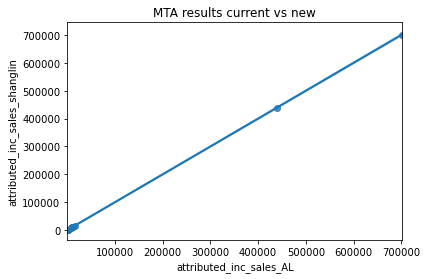

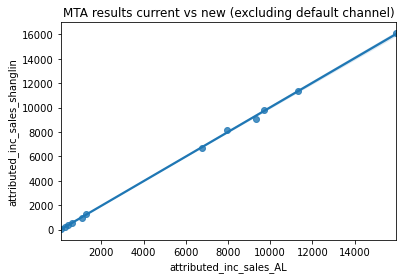

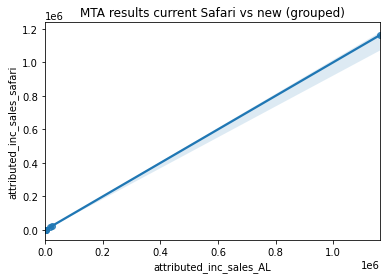

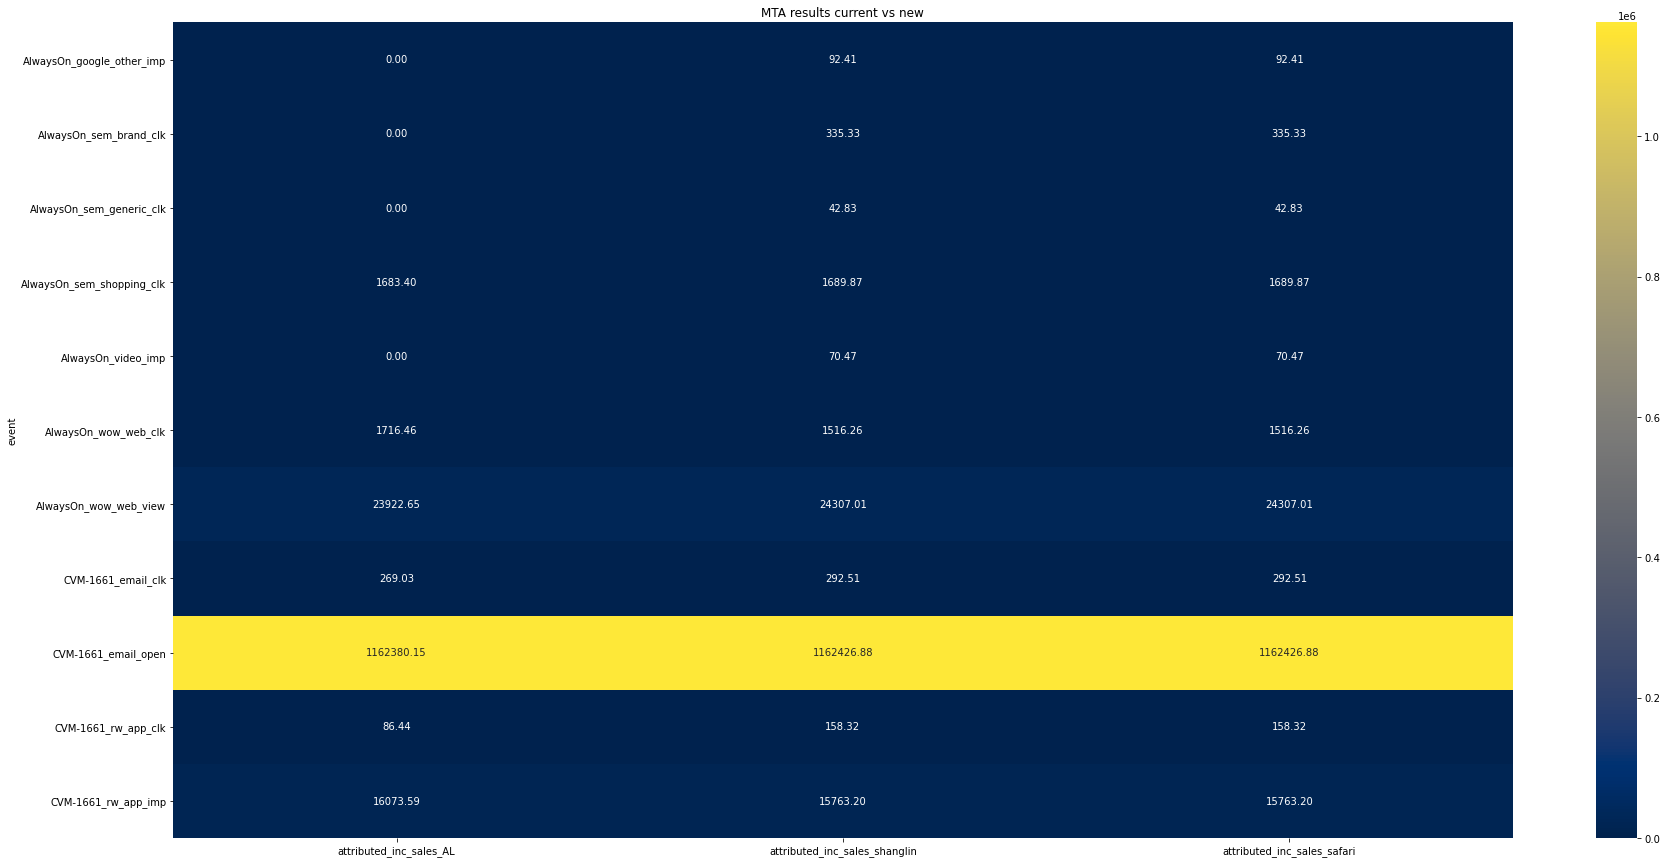

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000000                    0.001999   
AlwaysOn_sem_brand_clk                 0.000000                    0.019113   
AlwaysOn_sem_generic_clk               0.000000                    0.003000   
AlwaysOn_sem_shopping_clk              0.049505                    0.101859   
AlwaysOn_video_imp                     0.000000                    0.003049   
AlwaysOn_wow_web_clk                   0.098833                    0.269917   
AlwaysOn_wow_web_view                  0.253772                    0.874875   
CVM-1661_email_clk                     0.056400                    0.063758   
CVM-1661_email_open                    0.303277                    0.492521   
CVM-1661_rw_app_clk                    0.016620                    0.015462   
CVM-1661_rw_app_imp                    0.221594                    0.154433   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             0.000000e+00   
AlwaysOn_sem_brand_clk                0.000000e+00   
AlwaysOn_sem_generic_clk              0.000000e+00   
AlwaysOn_sem_shopping_clk             1.683403e+03   
AlwaysOn_video_imp                    0.000000e+00   
AlwaysOn_wow_web_clk                  1.716460e+03   
AlwaysOn_wow_web_view                 2.392265e+04   
CVM-1661_email_clk                    2.690297e+02   
CVM-1661_email_open                   1.162380e+06   
CVM-1661_rw_app_clk                   8.643623e+01   
CVM-1661_rw_app_imp                   1.607359e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   9.240940e+01   
AlwaysOn_sem_brand_clk                      3.353287e+02   
AlwaysOn_sem_generic_clk                    4.283102e+01   
AlwaysOn_sem_shopping_clk                   1.689867e+03   
AlwaysOn_video_imp                          7.047486e+01   
AlwaysOn_wow_web_clk                        1.516260e+03   
AlwaysOn_wow_web_view                       2.430701e+04   
CVM-1661_email_clk                          2.925102e+02   
CVM-1661_email_open                         1.162427e+06   
CVM-1661_rw_app_clk                         1.583201e+02   
CVM-1661_rw_app_imp                         1.576320e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                 9.240940e+01  
AlwaysOn_sem_brand_clk                    3.353287e+02  
AlwaysOn_sem_generic_clk                  4.283102e+01  
AlwaysOn_sem_shopping_clk                 1.689867e+03  
AlwaysOn_video_imp                        7.047486e+01  
AlwaysOn_wow_web_clk                      1.516260e+03  
AlwaysOn_wow_web_view                     2.430701e+04  
CVM-1661_email_clk                        2.925102e+02  
CVM-1661_email_open                       1.162427e+06  
CVM-1661_rw_app_clk                       1.583201e+02  
CVM-1661_rw_app_imp                       1.576320e+04

In [9]:
run_downstream_process(fpath_results="01_results/res_CVM-1661_2021-04-26_2021-05-02_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-26",
                       safari_run_date="2021-05-04",
                       fpath_comparison_results="02_comparison/res")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


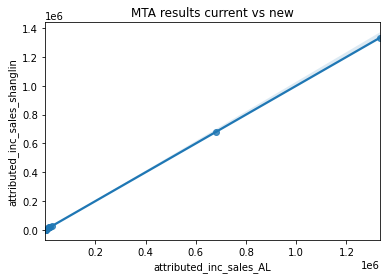

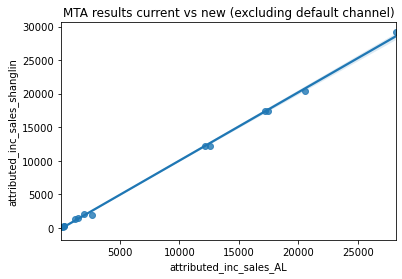

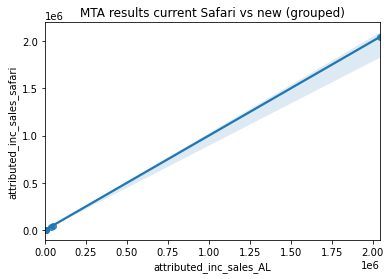

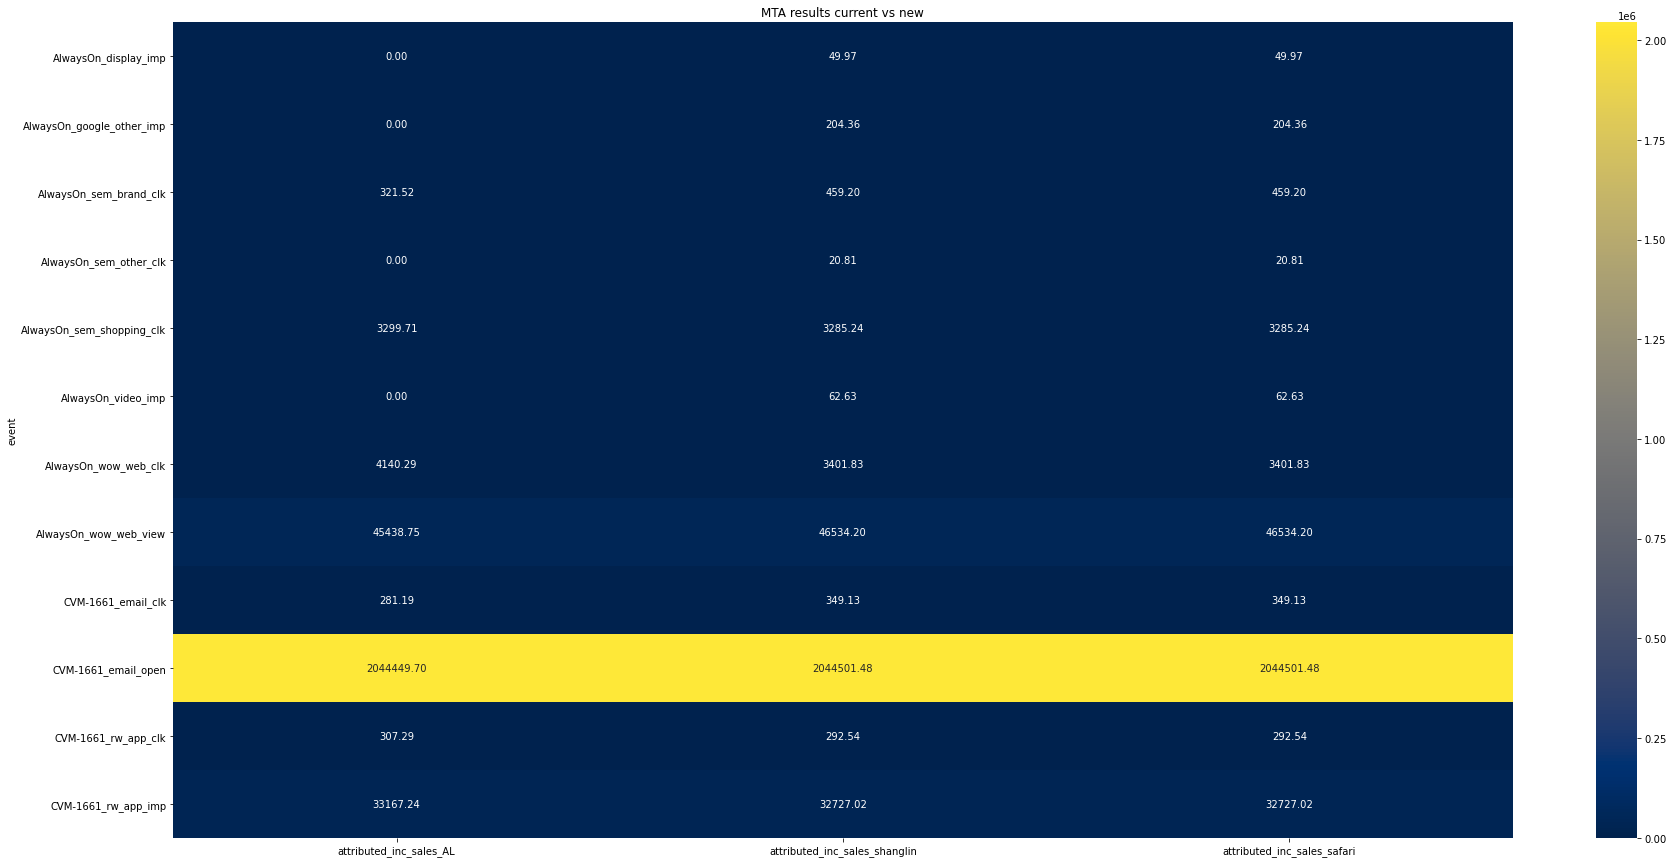

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.000000                    0.002089   
AlwaysOn_google_other_imp              0.000000                    0.004139   
AlwaysOn_sem_brand_clk                 0.006238                    0.014606   
AlwaysOn_sem_other_clk                 0.000000                    0.001044   
AlwaysOn_sem_shopping_clk              0.051923                    0.097585   
AlwaysOn_video_imp                     0.000000                    0.001044   
AlwaysOn_wow_web_clk                   0.122849                    0.301234   
AlwaysOn_wow_web_view                  0.277117                    0.916371   
CVM-1661_email_clk                     0.034943                    0.045611   
CVM-1661_email_open                    0.207058                    0.383676   
CVM-1661_rw_app_clk                    0.028647                    0.020802   
CVM-1661_rw_app_imp                    0.271226                    0.211785   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                  0.000000e+00   
AlwaysOn_google_other_imp             0.000000e+00   
AlwaysOn_sem_brand_clk                3.215239e+02   
AlwaysOn_sem_other_clk                0.000000e+00   
AlwaysOn_sem_shopping_clk             3.299709e+03   
AlwaysOn_video_imp                    0.000000e+00   
AlwaysOn_wow_web_clk                  4.140293e+03   
AlwaysOn_wow_web_view                 4.543875e+04   
CVM-1661_email_clk                    2.811851e+02   
CVM-1661_email_open                   2.044450e+06   
CVM-1661_rw_app_clk                   3.072943e+02   
CVM-1661_rw_app_imp                   3.316724e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        4.997245e+01   
AlwaysOn_google_other_imp                   2.043565e+02   
AlwaysOn_sem_brand_clk                      4.591961e+02   
AlwaysOn_sem_other_clk                      2.080579e+01   
AlwaysOn_sem_shopping_clk                   3.285235e+03   
AlwaysOn_video_imp                          6.263139e+01   
AlwaysOn_wow_web_clk                        3.401833e+03   
AlwaysOn_wow_web_view                       4.653420e+04   
CVM-1661_email_clk                          3.491335e+02   
CVM-1661_email_open                         2.044501e+06   
CVM-1661_rw_app_clk                         2.925442e+02   
CVM-1661_rw_app_imp                         3.272702e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                      4.997245e+01  
AlwaysOn_google_other_imp                 2.043565e+02  
AlwaysOn_sem_brand_clk                    4.591961e+02  
AlwaysOn_sem_other_clk                    2.080579e+01  
AlwaysOn_sem_shopping_clk                 3.285235e+03  
AlwaysOn_video_imp                        6.263139e+01  
AlwaysOn_wow_web_clk                      3.401833e+03  
AlwaysOn_wow_web_view                     4.653420e+04  
CVM-1661_email_clk                        3.491335e+02  
CVM-1661_email_open                       2.044501e+06  
CVM-1661_rw_app_clk                       2.925442e+02  
CVM-1661_rw_app_imp                       3.272702e+04

In [10]:
run_downstream_process(fpath_results="01_results/res_CVM-1661_2021-04-19_2021-04-25_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-19",
                       safari_run_date="2021-04-27",
                       fpath_comparison_results="02_comparison/res")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


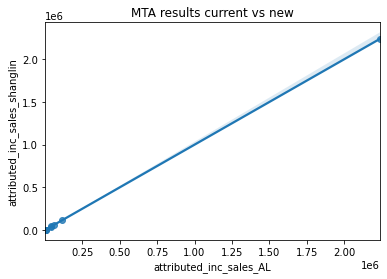

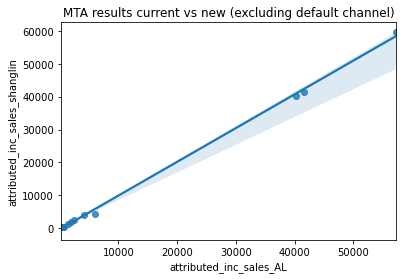

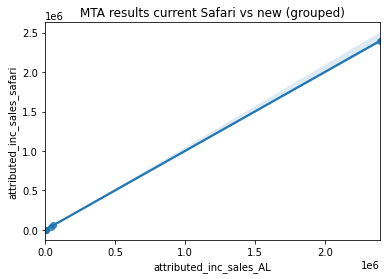

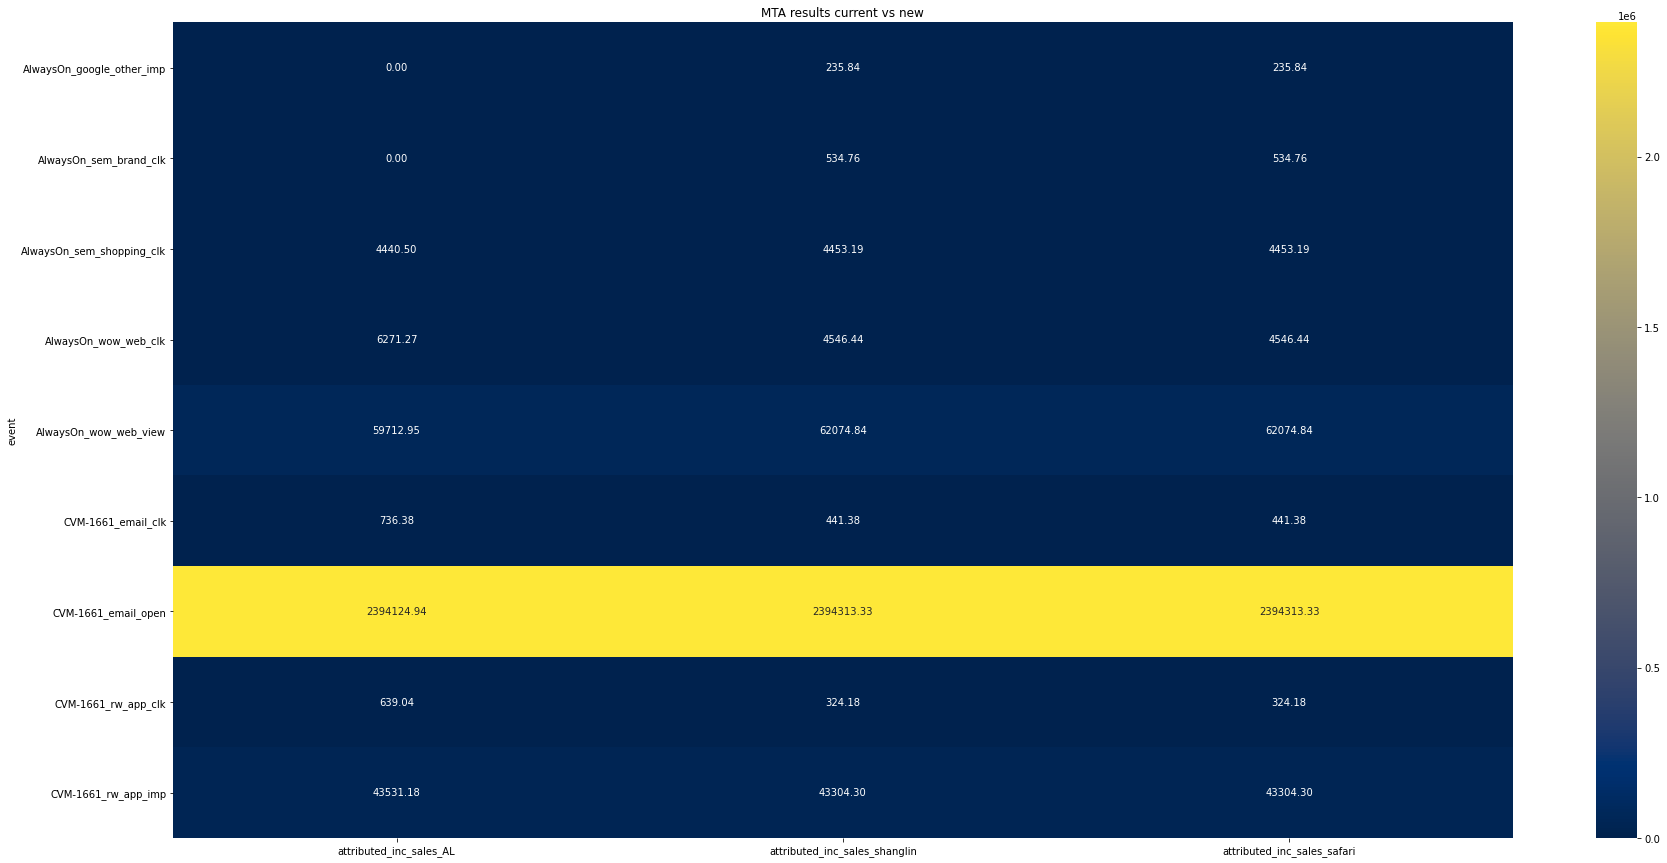

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000000                    0.004158   
AlwaysOn_sem_brand_clk                 0.000000                    0.010319   
AlwaysOn_sem_shopping_clk              0.039188                    0.087921   
AlwaysOn_wow_web_clk                   0.114094                    0.297305   
AlwaysOn_wow_web_view                  0.250427                    0.897570   
CVM-1661_email_clk                     0.049084                    0.036781   
CVM-1661_email_open                    0.254408                    0.420536   
CVM-1661_rw_app_clk                    0.030486                    0.014591   
CVM-1661_rw_app_imp                    0.262314                    0.230808   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             0.000000e+00   
AlwaysOn_sem_brand_clk                0.000000e+00   
AlwaysOn_sem_shopping_clk             4.440497e+03   
AlwaysOn_wow_web_clk                  6.271268e+03   
AlwaysOn_wow_web_view                 5.971295e+04   
CVM-1661_email_clk                    7.363776e+02   
CVM-1661_email_open                   2.394125e+06   
CVM-1661_rw_app_clk                   6.390412e+02   
CVM-1661_rw_app_imp                   4.353118e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   2.358374e+02   
AlwaysOn_sem_brand_clk                      5.347587e+02   
AlwaysOn_sem_shopping_clk                   4.453191e+03   
AlwaysOn_wow_web_clk                        4.546441e+03   
AlwaysOn_wow_web_view                       6.207484e+04   
CVM-1661_email_clk                          4.413760e+02   
CVM-1661_email_open                         2.394313e+06   
CVM-1661_rw_app_clk                         3.241835e+02   
CVM-1661_rw_app_imp                         4.330430e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                 2.358374e+02  
AlwaysOn_sem_brand_clk                    5.347587e+02  
AlwaysOn_sem_shopping_clk                 4.453191e+03  
AlwaysOn_wow_web_clk                      4.546441e+03  
AlwaysOn_wow_web_view                     6.207484e+04  
CVM-1661_email_clk                        4.413760e+02  
CVM-1661_email_open                       2.394313e+06  
CVM-1661_rw_app_clk                       3.241835e+02  
CVM-1661_rw_app_imp                       4.330430e+04

In [11]:
run_downstream_process(fpath_results="01_results/res_CVM-1661_2021-04-12_2021-04-18_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-12",
                       safari_run_date="2021-04-21",
                       fpath_comparison_results="02_comparison/res")

# Historical runs
* Use regenerated historical data, rather than actuals

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


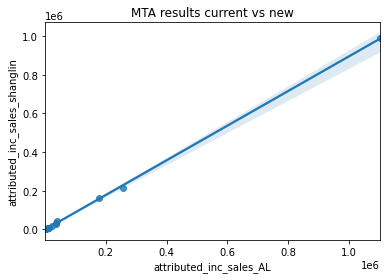

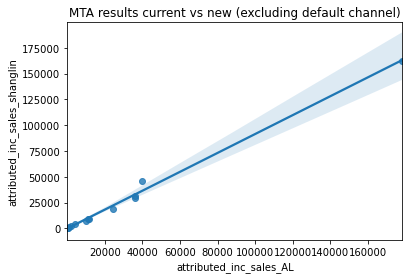

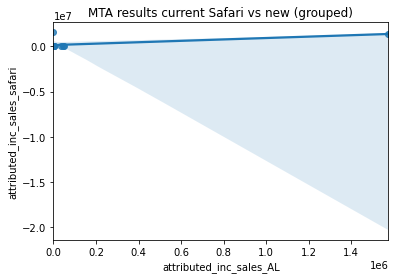

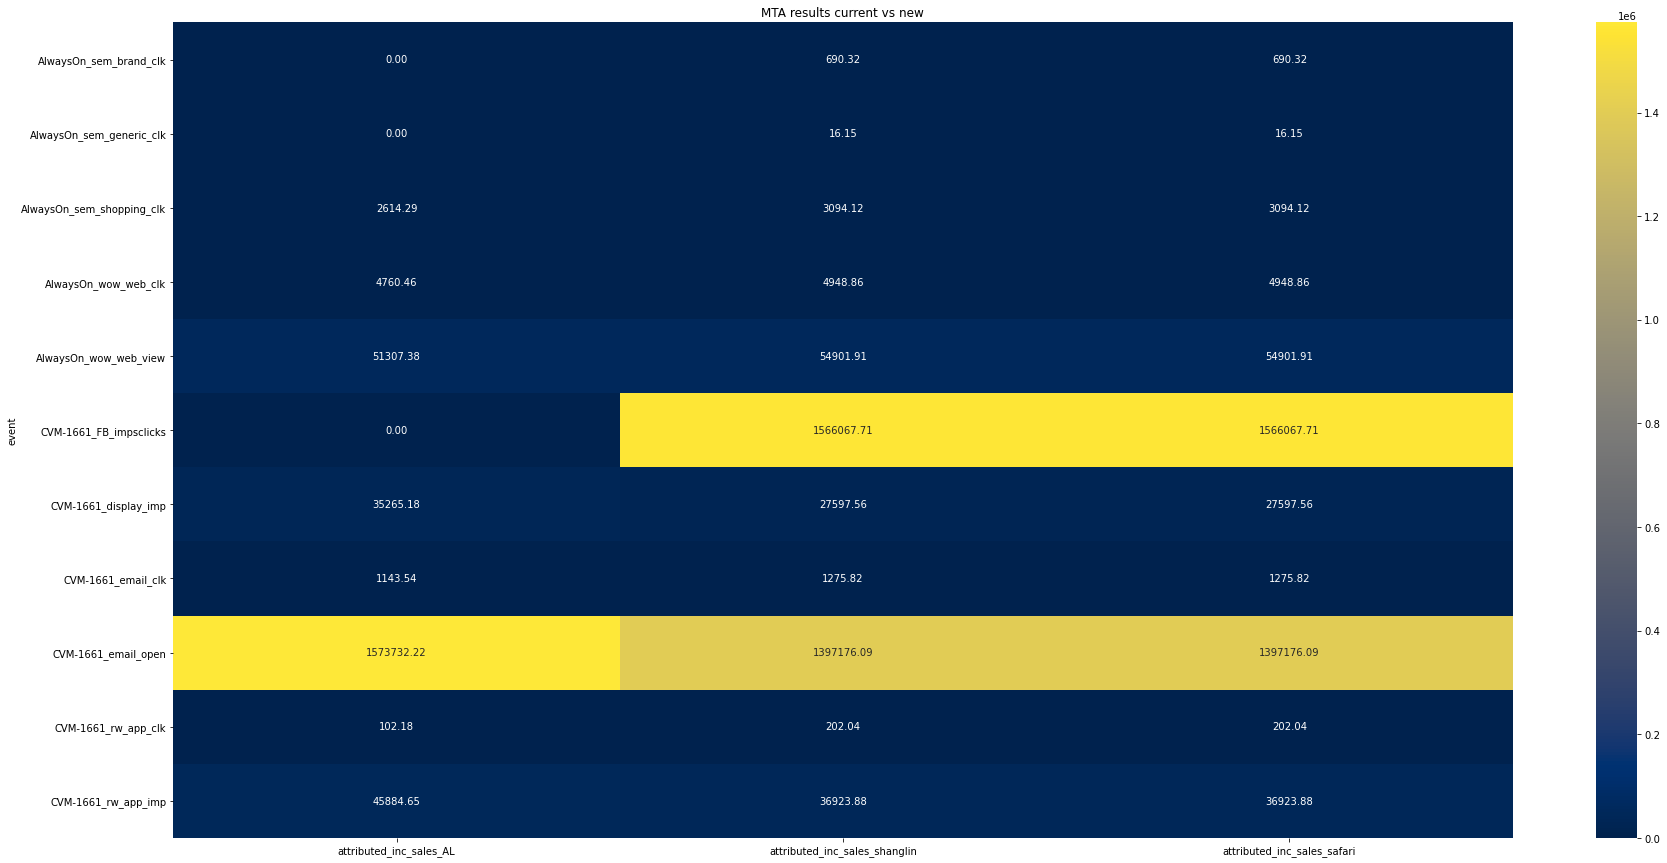

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-02-22 ... end of fw is 2021-02-28
	FB scaling ratio is (for missing slice of pie) 1.1090390522158855
	fb inc sales for CVM-1661 increased by 1.1090390521965823
	touchpoint count increased by 1185936


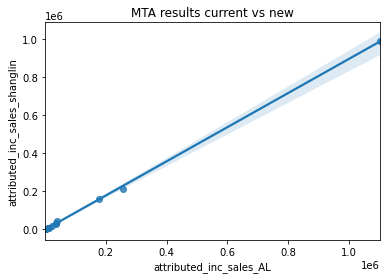

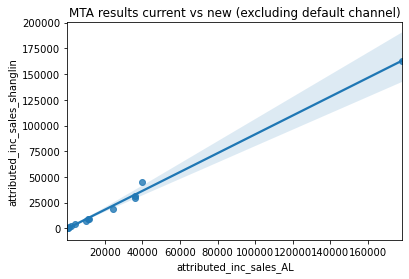

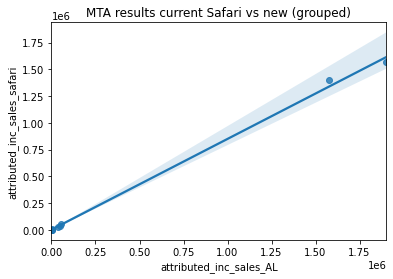

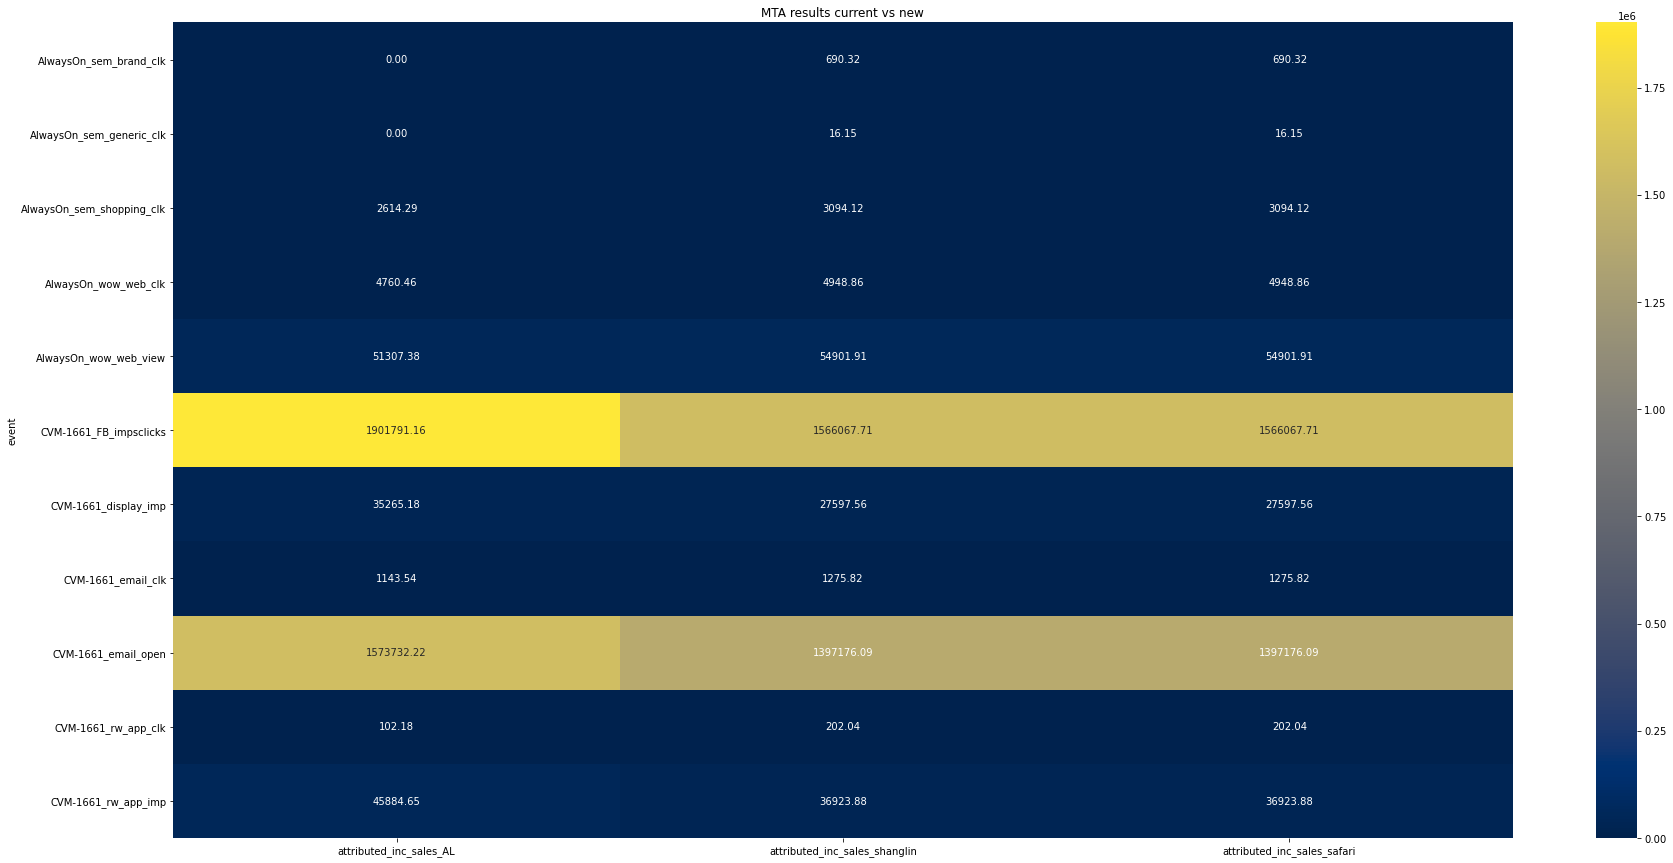

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000000                    0.009767   
AlwaysOn_sem_generic_clk               0.000000                    0.000979   
AlwaysOn_sem_shopping_clk              0.018868                    0.038998   
AlwaysOn_wow_web_clk                   0.040807                    0.126534   
AlwaysOn_wow_web_view                  0.121325                    0.360773   
CVM-1661_FB_impsclicks                -1.000000                    0.798132   
CVM-1661_display_imp                   0.104651                    0.082231   
CVM-1661_email_clk                     0.050680                    0.106737   
CVM-1661_email_open                    0.524353                    1.137930   
CVM-1661_rw_app_clk                    0.002852                    0.012002   
CVM-1661_rw_app_imp                    0.136463                    0.124036   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                0.000000e+00   
AlwaysOn_sem_generic_clk              0.000000e+00   
AlwaysOn_sem_shopping_clk             2.614289e+03   
AlwaysOn_wow_web_clk                  4.760459e+03   
AlwaysOn_wow_web_view                 5.130738e+04   
CVM-1661_FB_impsclicks                1.901791e+06   
CVM-1661_display_imp                  3.526518e+04   
CVM-1661_email_clk                    1.143545e+03   
CVM-1661_email_open                   1.573732e+06   
CVM-1661_rw_app_clk                   1.021845e+02   
CVM-1661_rw_app_imp                   4.588465e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      6.903173e+02   
AlwaysOn_sem_generic_clk                    1.614837e+01   
AlwaysOn_sem_shopping_clk                   3.094124e+03   
AlwaysOn_wow_web_clk                        4.948862e+03   
AlwaysOn_wow_web_view                       5.490191e+04   
CVM-1661_FB_impsclicks                      1.566068e+06   
CVM-1661_display_imp                        2.759756e+04   
CVM-1661_email_clk                          1.275815e+03   
CVM-1661_email_open                         1.397176e+06   
CVM-1661_rw_app_clk                         2.020450e+02   
CVM-1661_rw_app_imp                         3.692388e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    6.903173e+02  
AlwaysOn_sem_generic_clk                  1.614837e+01  
AlwaysOn_sem_shopping_clk                 3.094124e+03  
AlwaysOn_wow_web_clk                      4.948862e+03  
AlwaysOn_wow_web_view                     5.490191e+04  
CVM-1661_FB_impsclicks                    1.566068e+06  
CVM-1661_display_imp                      2.759756e+04  
CVM-1661_email_clk                        1.275815e+03  
CVM-1661_email_open                       1.397176e+06  
CVM-1661_rw_app_clk                       2.020450e+02  
CVM-1661_rw_app_imp                       3.692388e+04

In [20]:
run_downstream_process(fpath_results="01_results/res_CVM-1661_2021-02-22_2021-02-28_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                        fw="2021-02-22",
                        safari_run_date="2021-03-03",
                        create_dacamp_prod_mc_final=True,
                        have_historical_marketable_crn=False,
                        use_xueyuans_mc_crn_output=True,
                        allocate_fb=True,
                       fpath_comparison_results="02_comparison/res")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


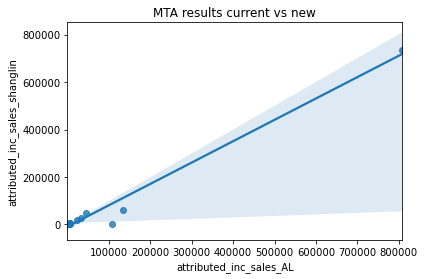

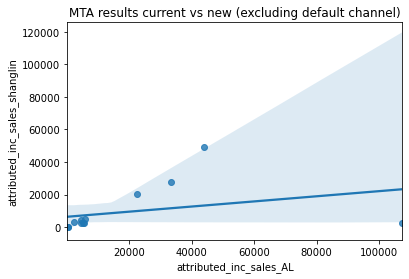

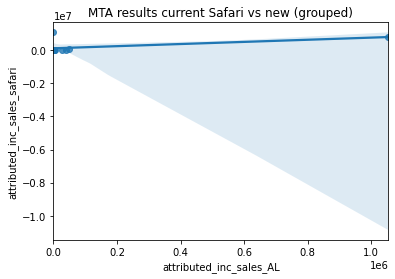

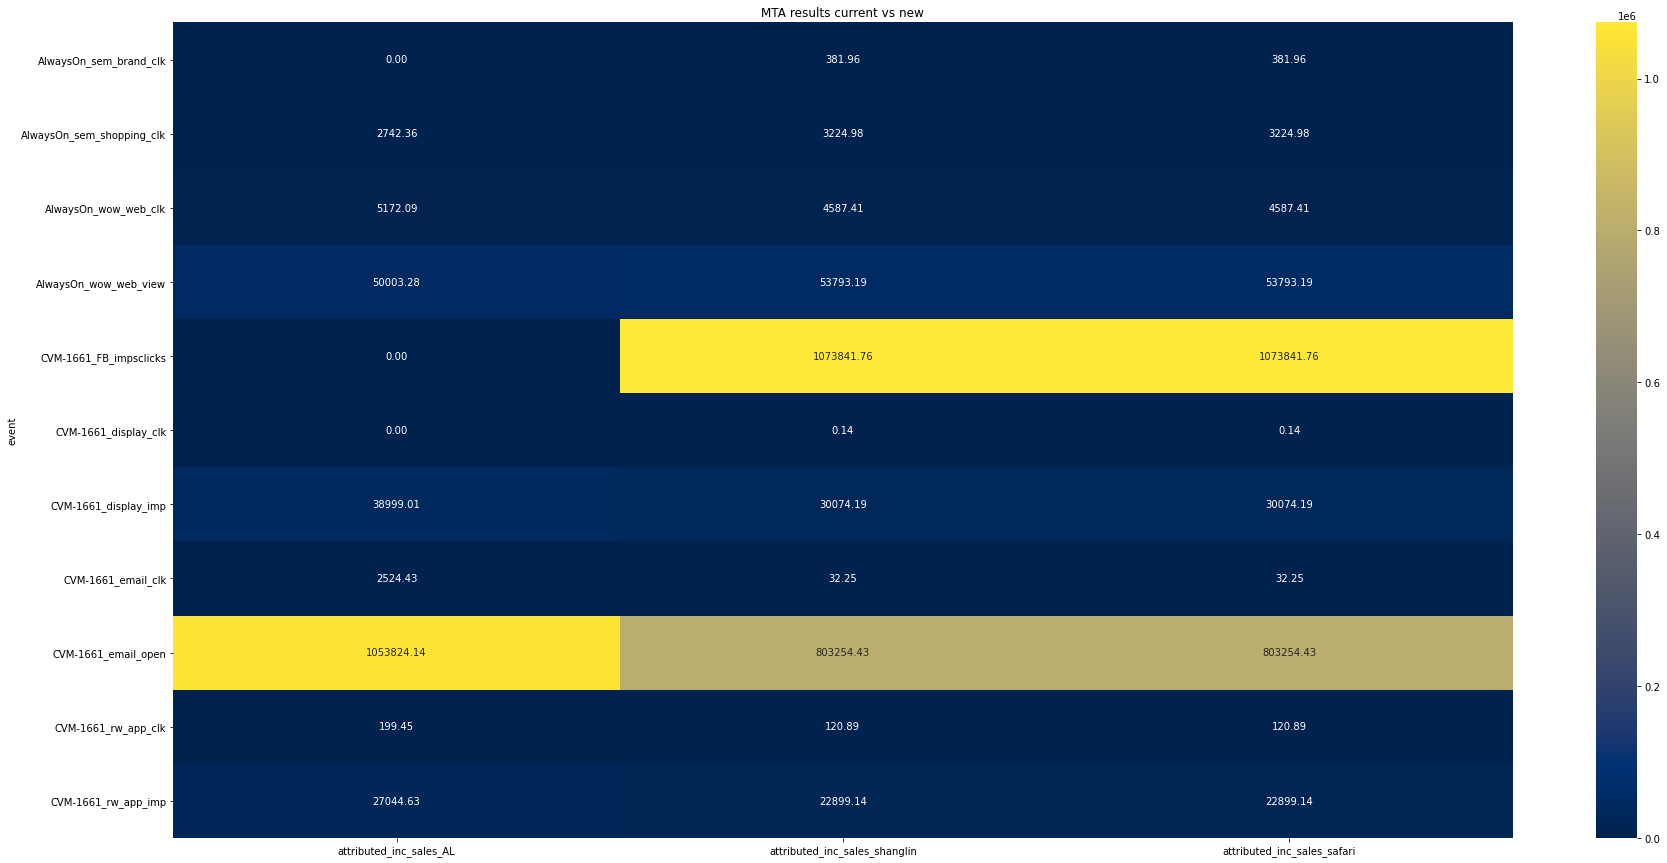

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-02-15 ... end of fw is 2021-02-21
	FB scaling ratio is (for missing slice of pie) 1.1836564171123019
	fb inc sales for CVM-1661 increased by 1.183656417690605
	touchpoint count increased by 1237739


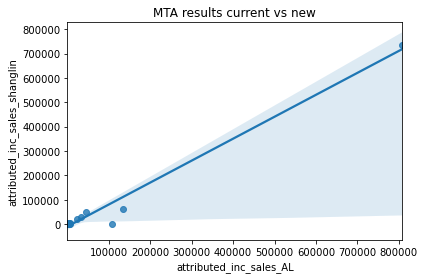

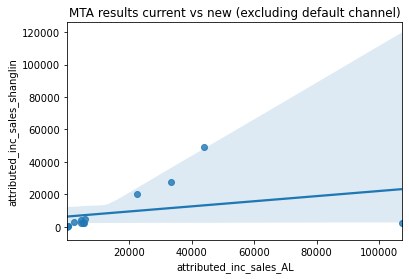

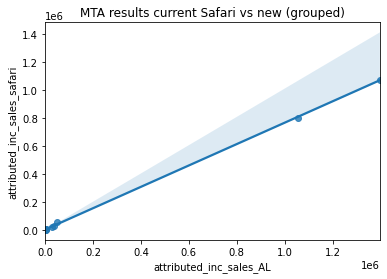

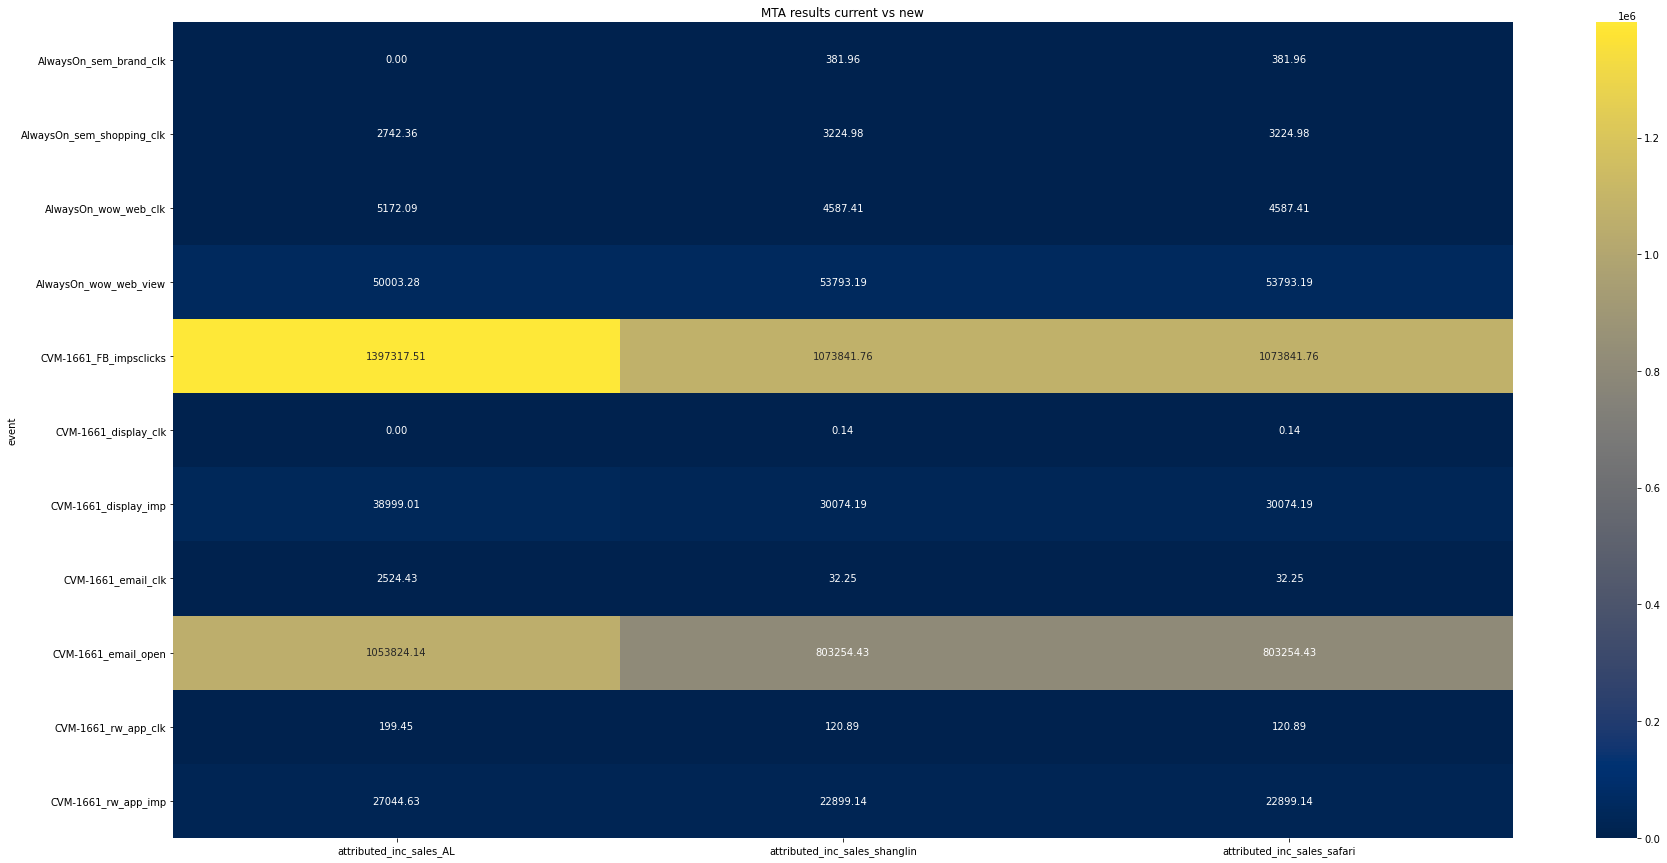

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000000                    0.014222   
AlwaysOn_sem_shopping_clk              0.021223                    0.093369   
AlwaysOn_wow_web_clk                   0.050301                    0.295317   
AlwaysOn_wow_web_view                  0.122828                    0.844584   
CVM-1661_FB_impsclicks                -1.000000                    0.249040   
CVM-1661_display_clk                   0.000000                    0.001080   
CVM-1661_display_imp                   0.181818                    0.190876   
CVM-1661_email_clk                     0.081049                    0.039908   
CVM-1661_email_open                    0.406417                    0.286693   
CVM-1661_rw_app_clk                    0.007186                    0.013514   
CVM-1661_rw_app_imp                    0.129178                    0.220425   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                0.000000e+00   
AlwaysOn_sem_shopping_clk             2.742359e+03   
AlwaysOn_wow_web_clk                  5.172085e+03   
AlwaysOn_wow_web_view                 5.000328e+04   
CVM-1661_FB_impsclicks                1.397318e+06   
CVM-1661_display_clk                  0.000000e+00   
CVM-1661_display_imp                  3.899901e+04   
CVM-1661_email_clk                    2.524432e+03   
CVM-1661_email_open                   1.053824e+06   
CVM-1661_rw_app_clk                   1.994528e+02   
CVM-1661_rw_app_imp                   2.704463e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      3.819618e+02   
AlwaysOn_sem_shopping_clk                   3.224982e+03   
AlwaysOn_wow_web_clk                        4.587406e+03   
AlwaysOn_wow_web_view                       5.379319e+04   
CVM-1661_FB_impsclicks                      1.073842e+06   
CVM-1661_display_clk                        1.353774e-01   
CVM-1661_display_imp                        3.007419e+04   
CVM-1661_email_clk                          3.225007e+01   
CVM-1661_email_open                         8.032544e+05   
CVM-1661_rw_app_clk                         1.208911e+02   
CVM-1661_rw_app_imp                         2.289914e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    3.819618e+02  
AlwaysOn_sem_shopping_clk                 3.224982e+03  
AlwaysOn_wow_web_clk                      4.587406e+03  
AlwaysOn_wow_web_view                     5.379319e+04  
CVM-1661_FB_impsclicks                    1.073842e+06  
CVM-1661_display_clk                      1.353774e-01  
CVM-1661_display_imp                      3.007419e+04  
CVM-1661_email_clk                        3.225007e+01  
CVM-1661_email_open                       8.032544e+05  
CVM-1661_rw_app_clk                       1.208911e+02  
CVM-1661_rw_app_imp                       2.289914e+04

In [21]:
run_downstream_process(fpath_results="01_results/res_CVM-1661_2021-02-15_2021-02-21_7.csv",
                       BQ_output_suffix="_CVM-1661",
                     campaign_code="CVM-1661",
                     fw="2021-02-15",
                     safari_run_date="2021-02-24",
                     create_dacamp_prod_mc_final=True,
                     have_historical_marketable_crn=False,
                     use_xueyuans_mc_crn_output=True,
                     allocate_fb=True,
                       fpath_comparison_results="02_comparison/res")

# Check runs weighted

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


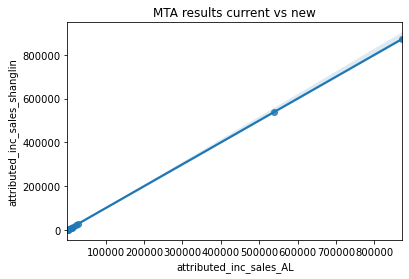

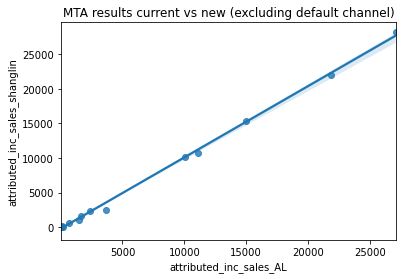

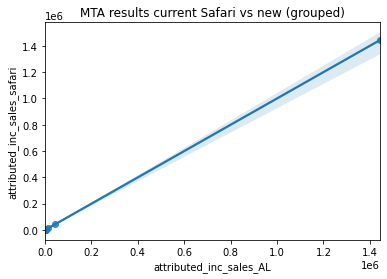

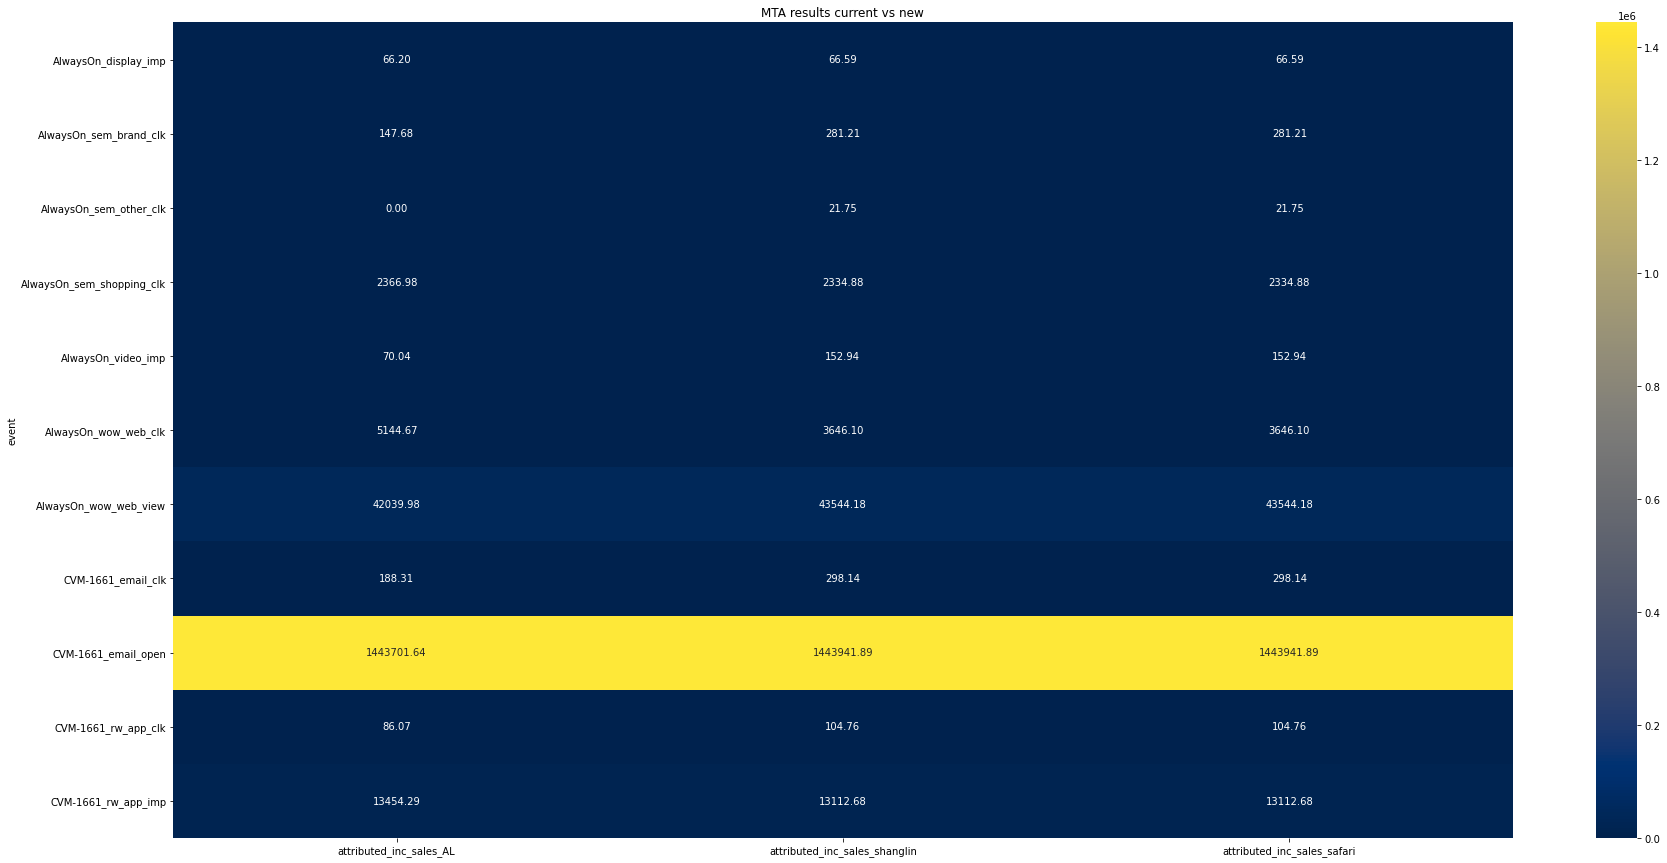

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.001027                    0.002034   
AlwaysOn_sem_brand_clk                 0.003517                    0.015018   
AlwaysOn_sem_other_clk                 0.000000                    0.000979   
AlwaysOn_sem_shopping_clk              0.044333                    0.067866   
AlwaysOn_video_imp                     0.000713                    0.002976   
AlwaysOn_wow_web_clk                   0.178296                    0.276109   
AlwaysOn_wow_web_view                  0.312855                    0.802838   
CVM-1661_email_clk                     0.034343                    0.060997   
CVM-1661_email_open                    0.222585                    0.624765   
CVM-1661_rw_app_clk                    0.019062                    0.011838   
CVM-1661_rw_app_imp                    0.183269                    0.134566   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                  6.620012e+01   
AlwaysOn_sem_brand_clk                1.476797e+02   
AlwaysOn_sem_other_clk                0.000000e+00   
AlwaysOn_sem_shopping_clk             2.366983e+03   
AlwaysOn_video_imp                    7.003826e+01   
AlwaysOn_wow_web_clk                  5.144671e+03   
AlwaysOn_wow_web_view                 4.203998e+04   
CVM-1661_email_clk                    1.883148e+02   
CVM-1661_email_open                   1.443702e+06   
CVM-1661_rw_app_clk                   8.606672e+01   
CVM-1661_rw_app_imp                   1.345429e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        6.659036e+01   
AlwaysOn_sem_brand_clk                      2.812059e+02   
AlwaysOn_sem_other_clk                      2.175456e+01   
AlwaysOn_sem_shopping_clk                   2.334876e+03   
AlwaysOn_video_imp                          1.529365e+02   
AlwaysOn_wow_web_clk                        3.646101e+03   
AlwaysOn_wow_web_view                       4.354418e+04   
CVM-1661_email_clk                          2.981435e+02   
CVM-1661_email_open                         1.443942e+06   
CVM-1661_rw_app_clk                         1.047585e+02   
CVM-1661_rw_app_imp                         1.311268e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                      6.659036e+01  
AlwaysOn_sem_brand_clk                    2.812059e+02  
AlwaysOn_sem_other_clk                    2.175456e+01  
AlwaysOn_sem_shopping_clk                 2.334876e+03  
AlwaysOn_video_imp                        1.529365e+02  
AlwaysOn_wow_web_clk                      3.646101e+03  
AlwaysOn_wow_web_view                     4.354418e+04  
CVM-1661_email_clk                        2.981435e+02  
CVM-1661_email_open                       1.443942e+06  
CVM-1661_rw_app_clk                       1.047585e+02  
CVM-1661_rw_app_imp                       1.311268e+04

In [22]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-05-03_2021-05-09_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-05-03",
                       safari_run_date="2021-05-11",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,
                       use_xueyuans_mc_crn_output=False,
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


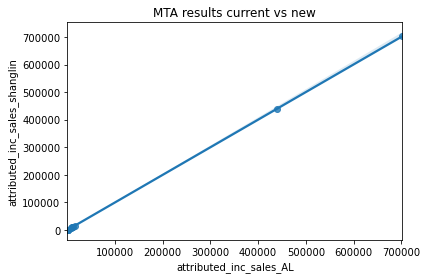

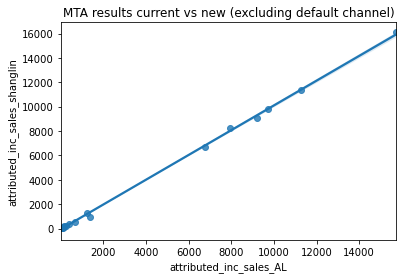

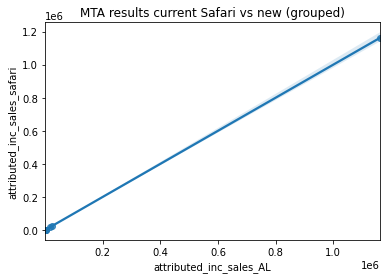

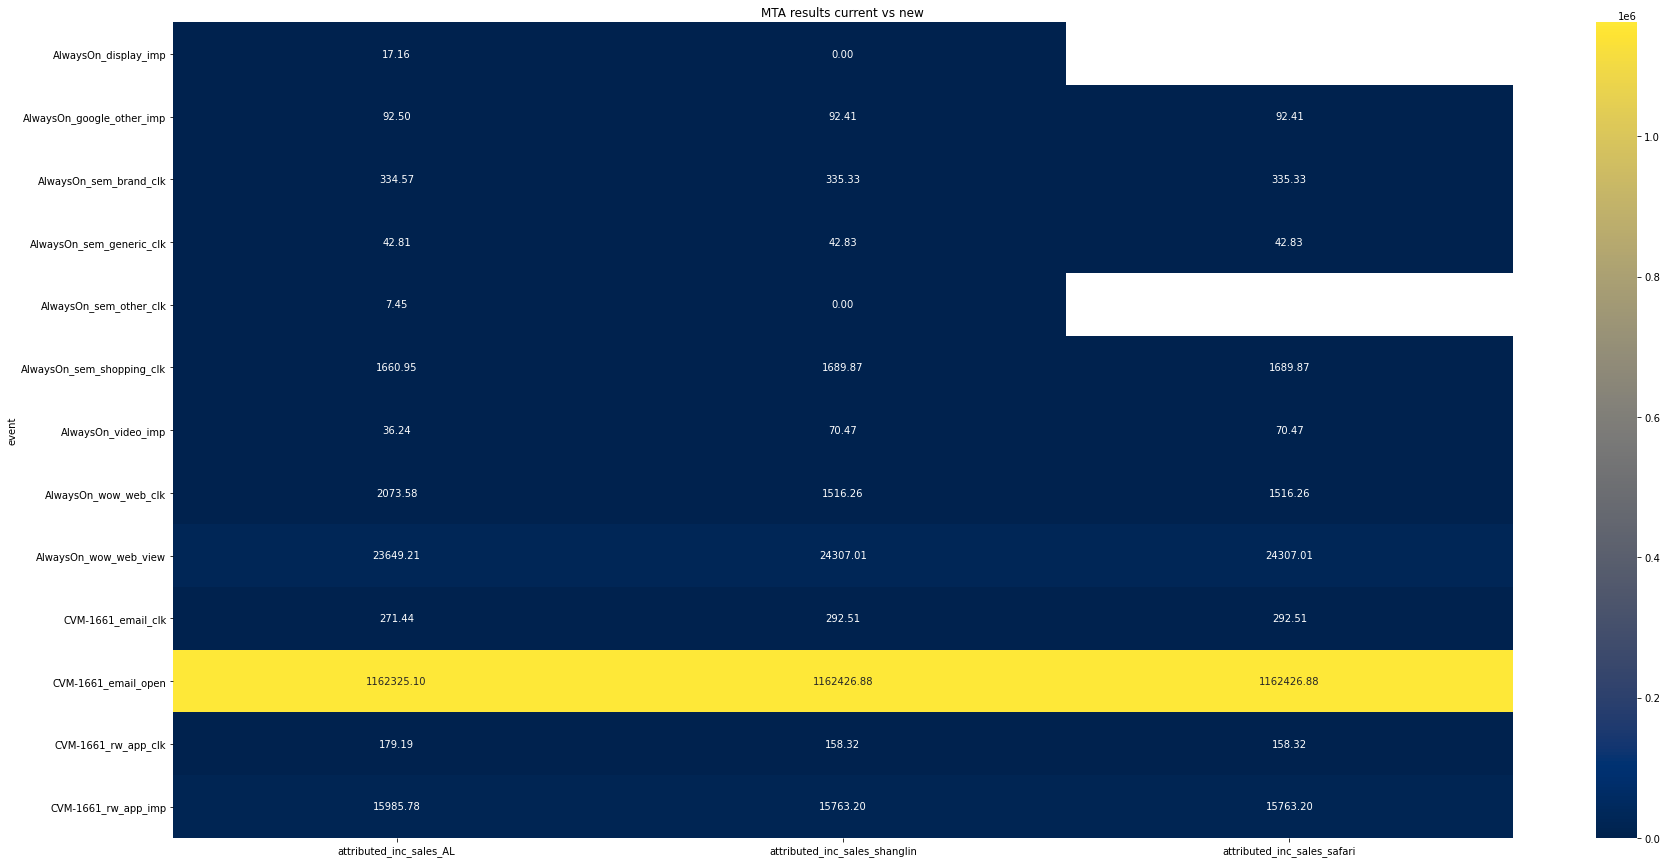

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.000070                    0.000000   
AlwaysOn_google_other_imp              0.001930                    0.001999   
AlwaysOn_sem_brand_clk                 0.002115                    0.019113   
AlwaysOn_sem_generic_clk               0.001407                    0.003000   
AlwaysOn_sem_other_clk                 0.000130                    0.000000   
AlwaysOn_sem_shopping_clk              0.030674                    0.101859   
AlwaysOn_video_imp                     0.000043                    0.003049   
AlwaysOn_wow_web_clk                   0.153581                    0.269917   
AlwaysOn_wow_web_view                  0.319339                    0.874875   
CVM-1661_email_clk                     0.038088                    0.063758   
CVM-1661_email_open                    0.206024                    0.492521   
CVM-1661_rw_app_clk                    0.027436                    0.015462   
CVM-1661_rw_app_imp                    0.219162                    0.154433   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                  1.716093e+01   
AlwaysOn_google_other_imp             9.249557e+01   
AlwaysOn_sem_brand_clk                3.345708e+02   
AlwaysOn_sem_generic_clk              4.280586e+01   
AlwaysOn_sem_other_clk                7.450748e+00   
AlwaysOn_sem_shopping_clk             1.660954e+03   
AlwaysOn_video_imp                    3.624038e+01   
AlwaysOn_wow_web_clk                  2.073585e+03   
AlwaysOn_wow_web_view                 2.364921e+04   
CVM-1661_email_clk                    2.714376e+02   
CVM-1661_email_open                   1.162325e+06   
CVM-1661_rw_app_clk                   1.791882e+02   
CVM-1661_rw_app_imp                   1.598578e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        0.000000e+00   
AlwaysOn_google_other_imp                   9.240940e+01   
AlwaysOn_sem_brand_clk                      3.353287e+02   
AlwaysOn_sem_generic_clk                    4.283102e+01   
AlwaysOn_sem_other_clk                      0.000000e+00   
AlwaysOn_sem_shopping_clk                   1.689867e+03   
AlwaysOn_video_imp                          7.047486e+01   
AlwaysOn_wow_web_clk                        1.516260e+03   
AlwaysOn_wow_web_view                       2.430701e+04   
CVM-1661_email_clk                          2.925102e+02   
CVM-1661_email_open                         1.162427e+06   
CVM-1661_rw_app_clk                         1.583201e+02   
CVM-1661_rw_app_imp                         1.576320e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                               NaN  
AlwaysOn_google_other_imp                 9.240940e+01  
AlwaysOn_sem_brand_clk                    3.353287e+02  
AlwaysOn_sem_generic_clk                  4.283102e+01  
AlwaysOn_sem_other_clk                             NaN  
AlwaysOn_sem_shopping_clk                 1.689867e+03  
AlwaysOn_video_imp                        7.047486e+01  
AlwaysOn_wow_web_clk                      1.516260e+03  
AlwaysOn_wow_web_view                     2.430701e+04  
CVM-1661_email_clk                        2.925102e+02  
CVM-1661_email_open                       1.162427e+06  
CVM-1661_rw_app_clk                       1.583201e+02  
CVM-1661_rw_app_imp                       1.576320e+04

In [23]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-04-26_2021-05-02_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-26",
                       safari_run_date="2021-05-04",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,
                       use_xueyuans_mc_crn_output=False,
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


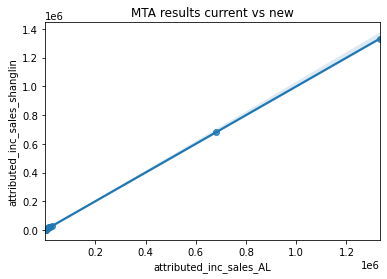

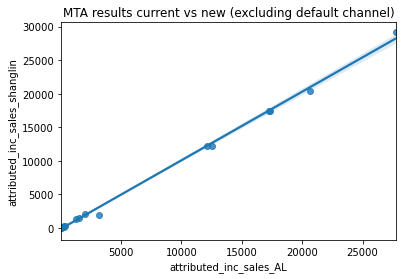

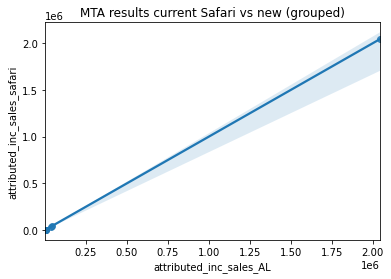

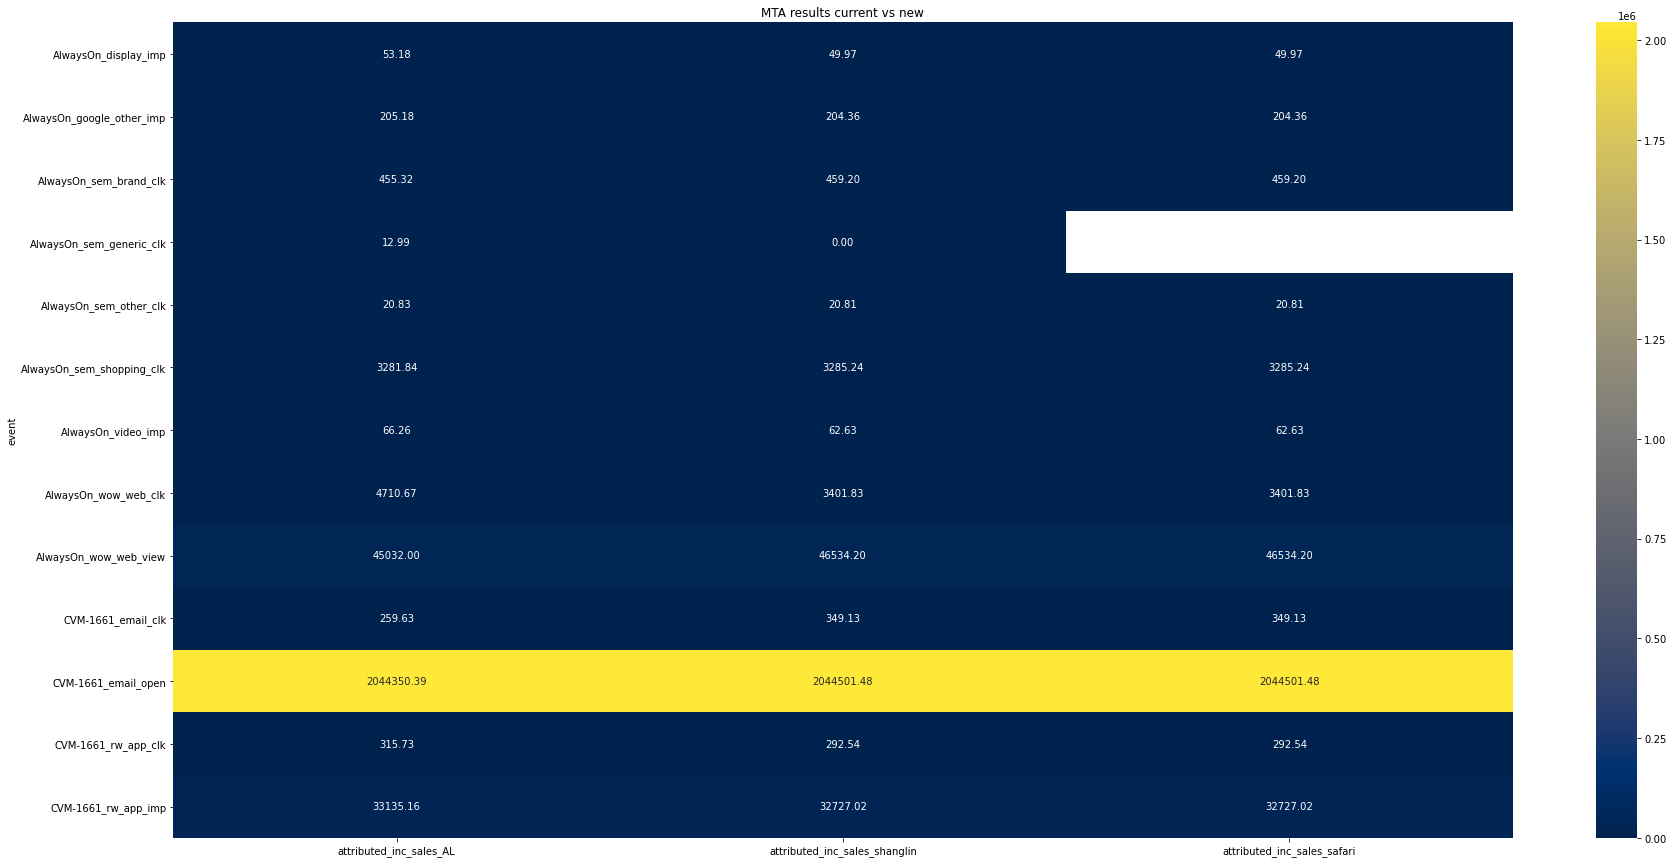

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.000681                    0.002089   
AlwaysOn_google_other_imp              0.003465                    0.004139   
AlwaysOn_sem_brand_clk                 0.003273                    0.014606   
AlwaysOn_sem_generic_clk               0.000337                    0.000000   
AlwaysOn_sem_other_clk                 0.000905                    0.001044   
AlwaysOn_sem_shopping_clk              0.045469                    0.097585   
AlwaysOn_video_imp                     0.000482                    0.001044   
AlwaysOn_wow_web_clk                   0.183054                    0.301234   
AlwaysOn_wow_web_view                  0.353331                    0.916371   
CVM-1661_email_clk                     0.018347                    0.045611   
CVM-1661_email_open                    0.118692                    0.383676   
CVM-1661_rw_app_clk                    0.027187                    0.020802   
CVM-1661_rw_app_imp                    0.244778                    0.211785   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                  5.318189e+01   
AlwaysOn_google_other_imp             2.051751e+02   
AlwaysOn_sem_brand_clk                4.553185e+02   
AlwaysOn_sem_generic_clk              1.299064e+01   
AlwaysOn_sem_other_clk                2.082814e+01   
AlwaysOn_sem_shopping_clk             3.281837e+03   
AlwaysOn_video_imp                    6.626388e+01   
AlwaysOn_wow_web_clk                  4.710673e+03   
AlwaysOn_wow_web_view                 4.503200e+04   
CVM-1661_email_clk                    2.596302e+02   
CVM-1661_email_open                   2.044350e+06   
CVM-1661_rw_app_clk                   3.157257e+02   
CVM-1661_rw_app_imp                   3.313516e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        4.997245e+01   
AlwaysOn_google_other_imp                   2.043565e+02   
AlwaysOn_sem_brand_clk                      4.591961e+02   
AlwaysOn_sem_generic_clk                    0.000000e+00   
AlwaysOn_sem_other_clk                      2.080579e+01   
AlwaysOn_sem_shopping_clk                   3.285235e+03   
AlwaysOn_video_imp                          6.263139e+01   
AlwaysOn_wow_web_clk                        3.401833e+03   
AlwaysOn_wow_web_view                       4.653420e+04   
CVM-1661_email_clk                          3.491335e+02   
CVM-1661_email_open                         2.044501e+06   
CVM-1661_rw_app_clk                         2.925442e+02   
CVM-1661_rw_app_imp                         3.272702e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                      4.997245e+01  
AlwaysOn_google_other_imp                 2.043565e+02  
AlwaysOn_sem_brand_clk                    4.591961e+02  
AlwaysOn_sem_generic_clk                           NaN  
AlwaysOn_sem_other_clk                    2.080579e+01  
AlwaysOn_sem_shopping_clk                 3.285235e+03  
AlwaysOn_video_imp                        6.263139e+01  
AlwaysOn_wow_web_clk                      3.401833e+03  
AlwaysOn_wow_web_view                     4.653420e+04  
CVM-1661_email_clk                        3.491335e+02  
CVM-1661_email_open                       2.044501e+06  
CVM-1661_rw_app_clk                       2.925442e+02  
CVM-1661_rw_app_imp                       3.272702e+04

In [24]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-04-19_2021-05-25_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-19",
                       safari_run_date="2021-04-27",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,
                       use_xueyuans_mc_crn_output=False,
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


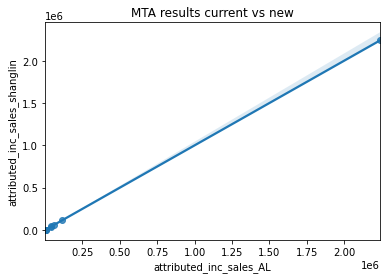

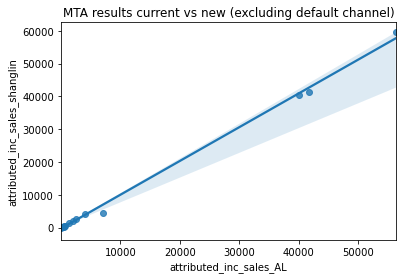

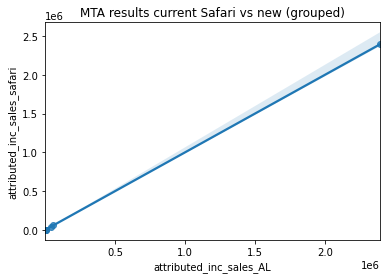

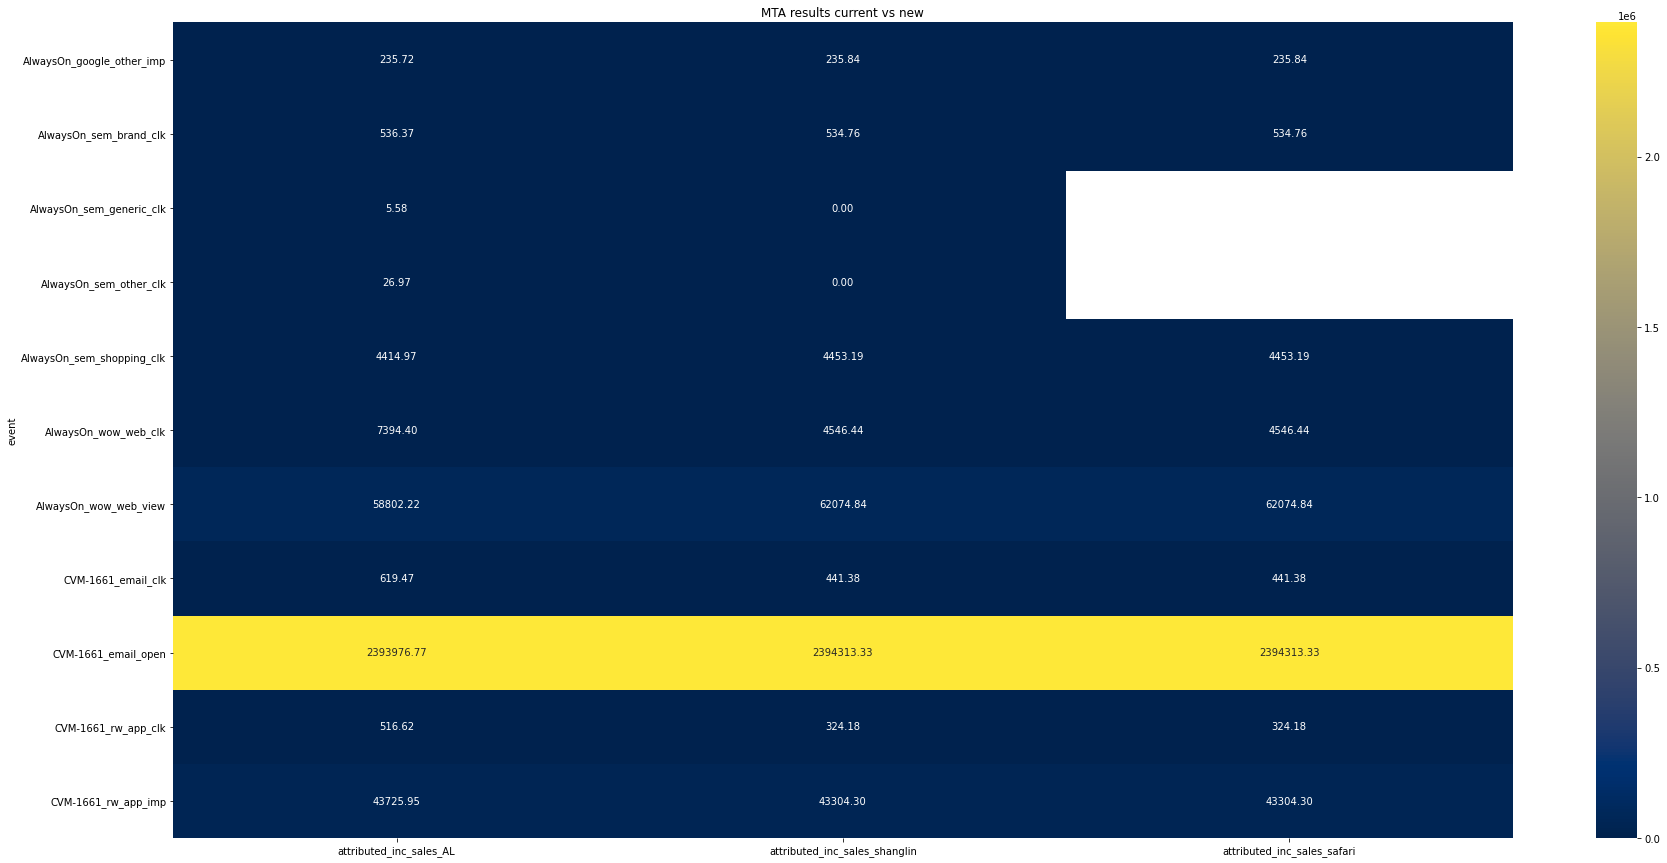

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.002823                    0.004158   
AlwaysOn_sem_brand_clk                 0.004625                    0.010319   
AlwaysOn_sem_generic_clk               0.000682                    0.000000   
AlwaysOn_sem_other_clk                 0.000347                    0.000000   
AlwaysOn_sem_shopping_clk              0.037314                    0.087921   
AlwaysOn_wow_web_clk                   0.177074                    0.297305   
AlwaysOn_wow_web_view                  0.324225                    0.897570   
CVM-1661_email_clk                     0.024156                    0.036781   
CVM-1661_email_open                    0.154953                    0.420536   
CVM-1661_rw_app_clk                    0.028424                    0.014591   
CVM-1661_rw_app_imp                    0.245377                    0.230808   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             2.357216e+02   
AlwaysOn_sem_brand_clk                5.363683e+02   
AlwaysOn_sem_generic_clk              5.583364e+00   
AlwaysOn_sem_other_clk                2.696726e+01   
AlwaysOn_sem_shopping_clk             4.414967e+03   
AlwaysOn_wow_web_clk                  7.394402e+03   
AlwaysOn_wow_web_view                 5.880222e+04   
CVM-1661_email_clk                    6.194745e+02   
CVM-1661_email_open                   2.393977e+06   
CVM-1661_rw_app_clk                   5.166227e+02   
CVM-1661_rw_app_imp                   4.372595e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   2.358374e+02   
AlwaysOn_sem_brand_clk                      5.347587e+02   
AlwaysOn_sem_generic_clk                    0.000000e+00   
AlwaysOn_sem_other_clk                      0.000000e+00   
AlwaysOn_sem_shopping_clk                   4.453191e+03   
AlwaysOn_wow_web_clk                        4.546441e+03   
AlwaysOn_wow_web_view                       6.207484e+04   
CVM-1661_email_clk                          4.413760e+02   
CVM-1661_email_open                         2.394313e+06   
CVM-1661_rw_app_clk                         3.241835e+02   
CVM-1661_rw_app_imp                         4.330430e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                 2.358374e+02  
AlwaysOn_sem_brand_clk                    5.347587e+02  
AlwaysOn_sem_generic_clk                           NaN  
AlwaysOn_sem_other_clk                             NaN  
AlwaysOn_sem_shopping_clk                 4.453191e+03  
AlwaysOn_wow_web_clk                      4.546441e+03  
AlwaysOn_wow_web_view                     6.207484e+04  
CVM-1661_email_clk                        4.413760e+02  
CVM-1661_email_open                       2.394313e+06  
CVM-1661_rw_app_clk                       3.241835e+02  
CVM-1661_rw_app_imp                       4.330430e+04

In [25]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-04-12_2021-05-18_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-04-12",
                       safari_run_date="2021-04-21",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,
                       use_xueyuans_mc_crn_output=False,
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


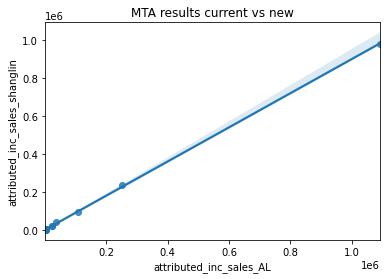

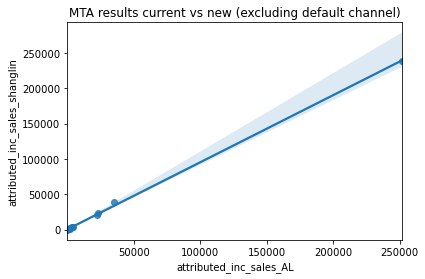

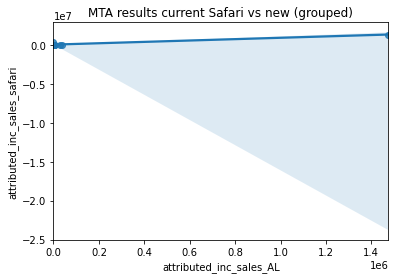

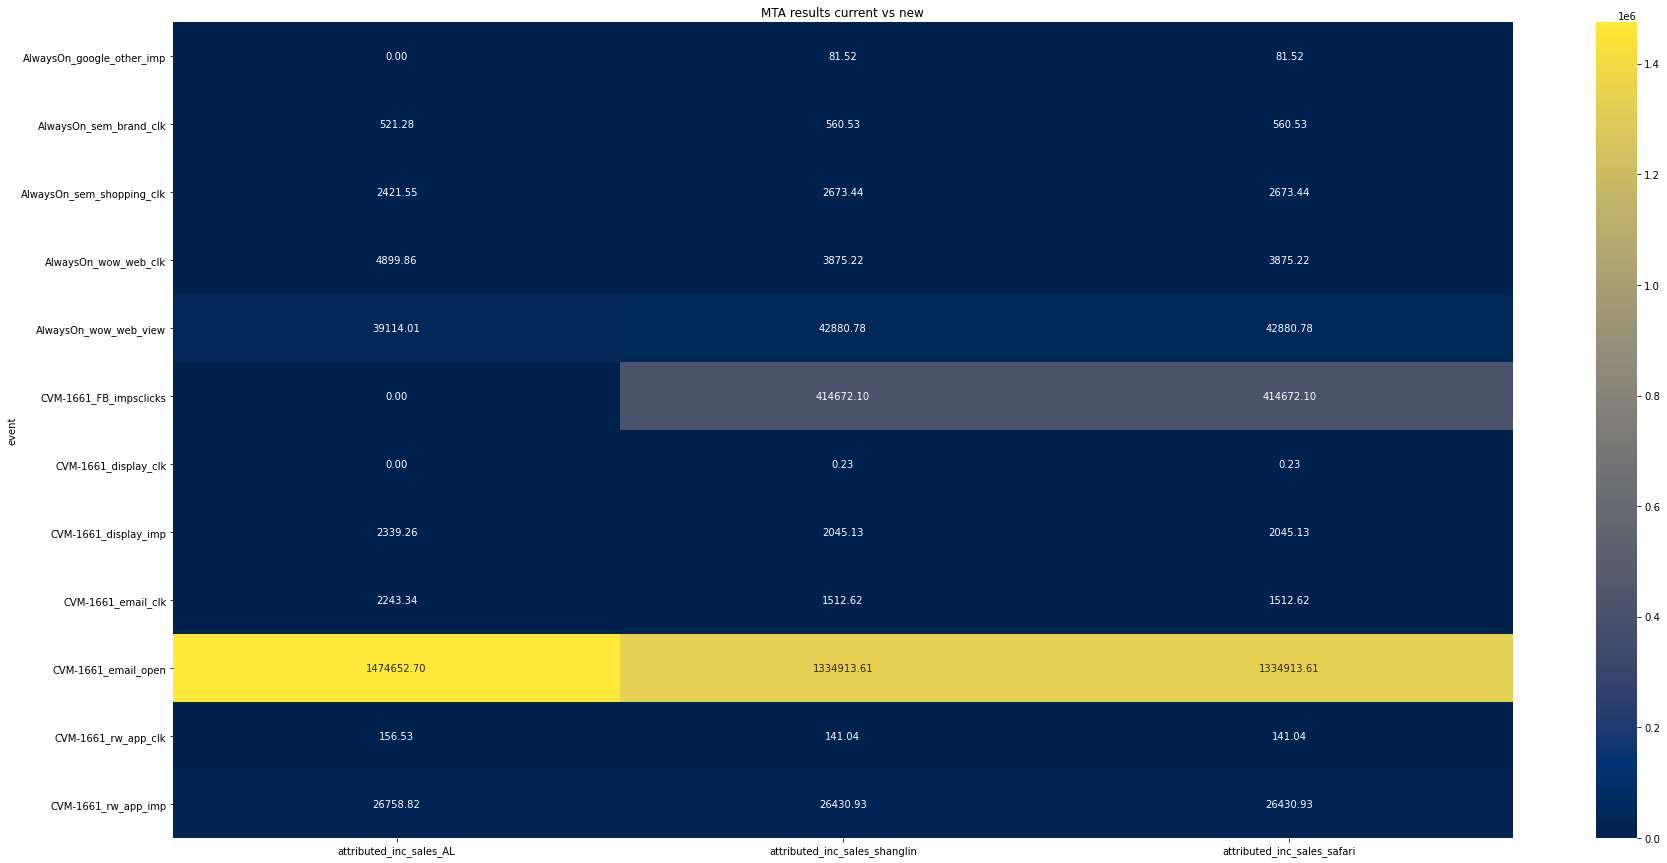

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-01 ... end of fw is 2021-03-07
	FB scaling ratio is (for missing slice of pie) 0.46981364167482026
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for CVM-1661 increased by 0.46981364214626603
	touchpoint count increased by 946799


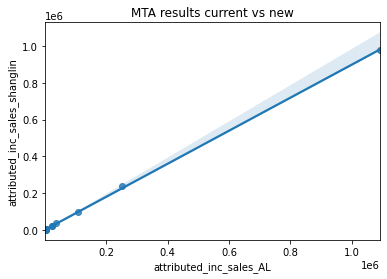

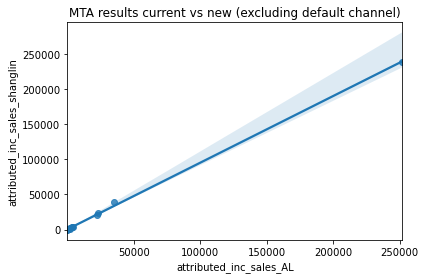

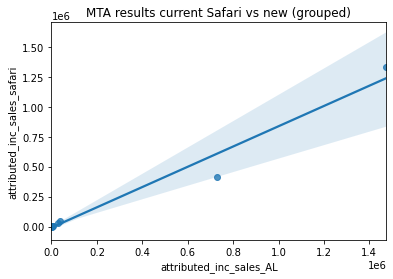

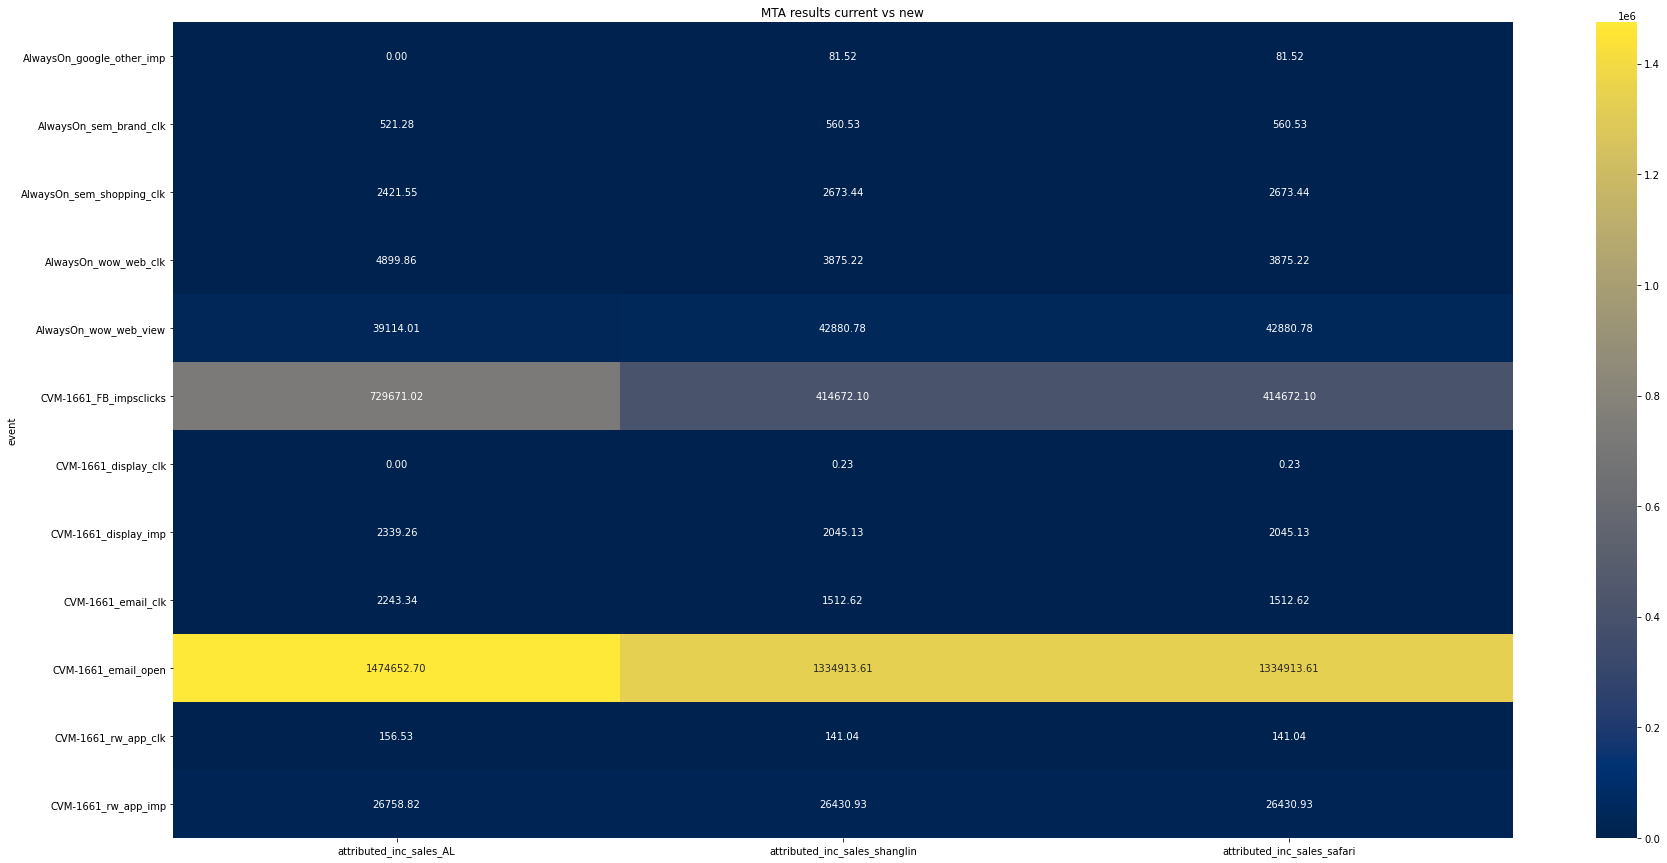

In [32]:
results = run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-03-01_2021-03-07_7.csv",
                                 BQ_output_suffix="_CVM-1661",
                                 campaign_code="CVM-1661",
                                 fw="2021-03-01",
                                 safari_run_date="2021-03-12",
                                 create_dacamp_prod_mc_final=True,
                                 have_historical_marketable_crn=False,
                                 use_xueyuans_mc_crn_output=True,
                                 allocate_fb=True,
                                 fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


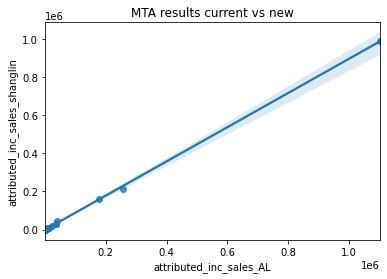

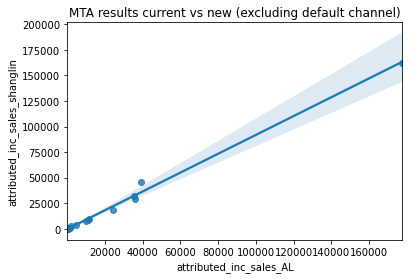

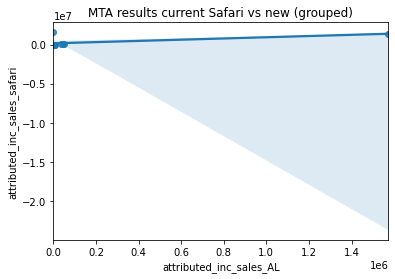

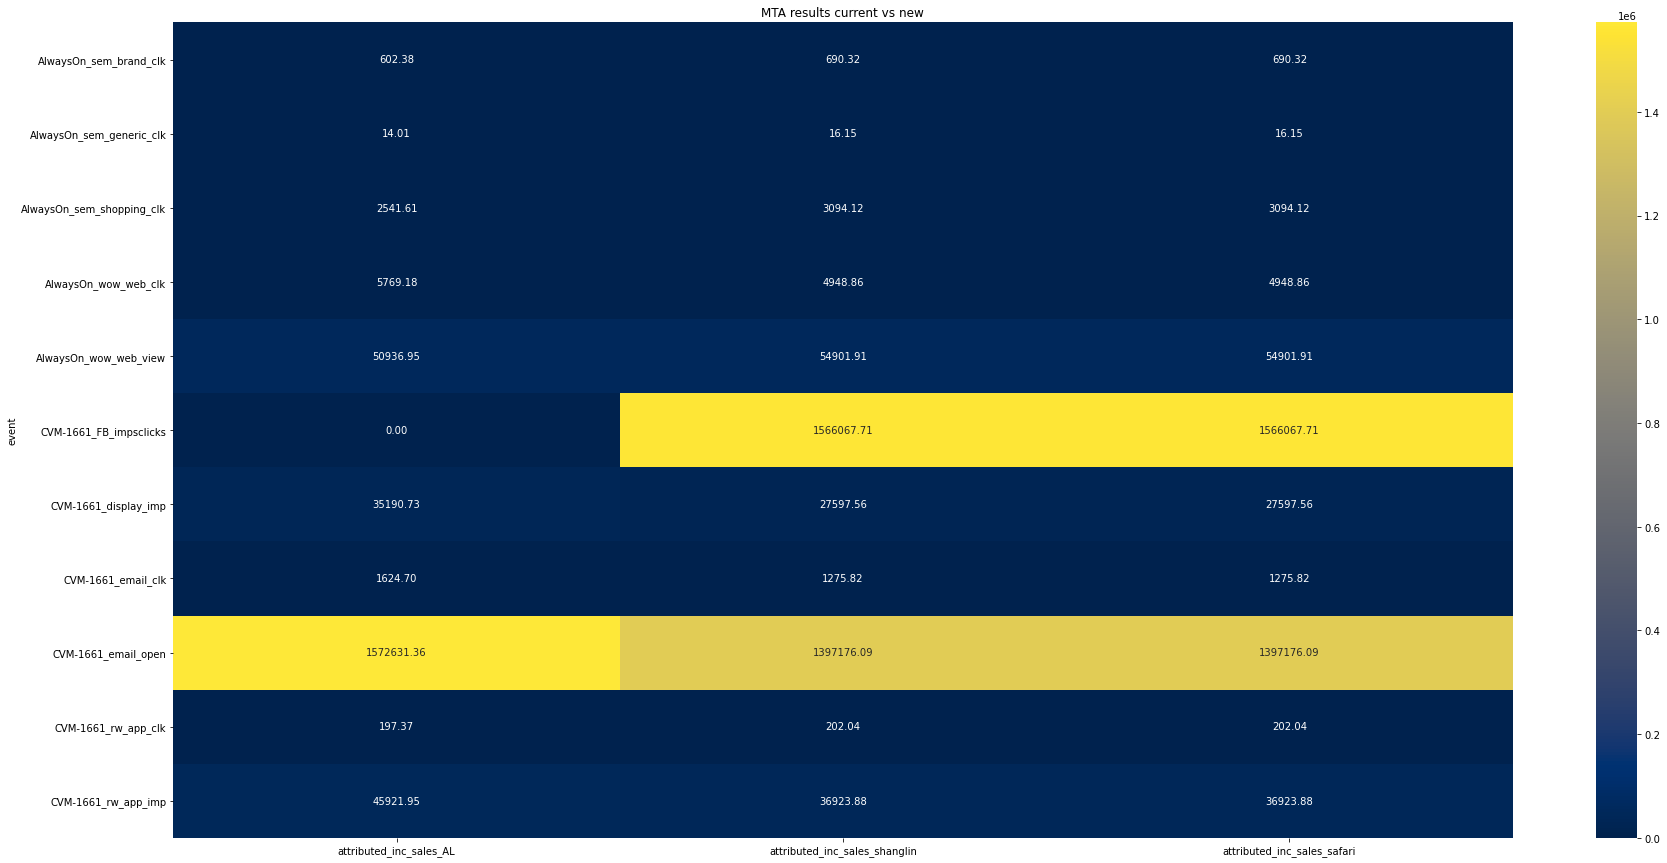

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-02-22 ... end of fw is 2021-02-28
	FB scaling ratio is (for missing slice of pie) 0.898005924560117
	fb inc sales for CVM-1661 increased by 0.8980059242529383
	touchpoint count increased by 1185936


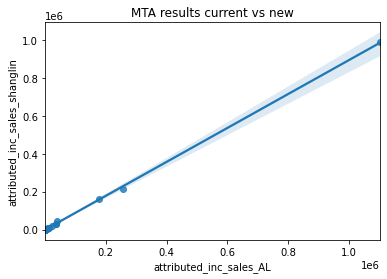

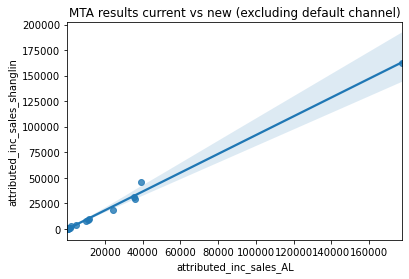

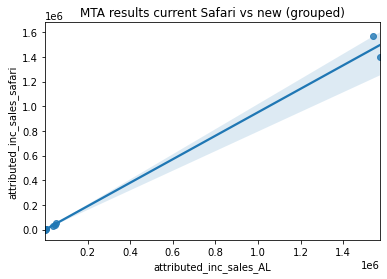

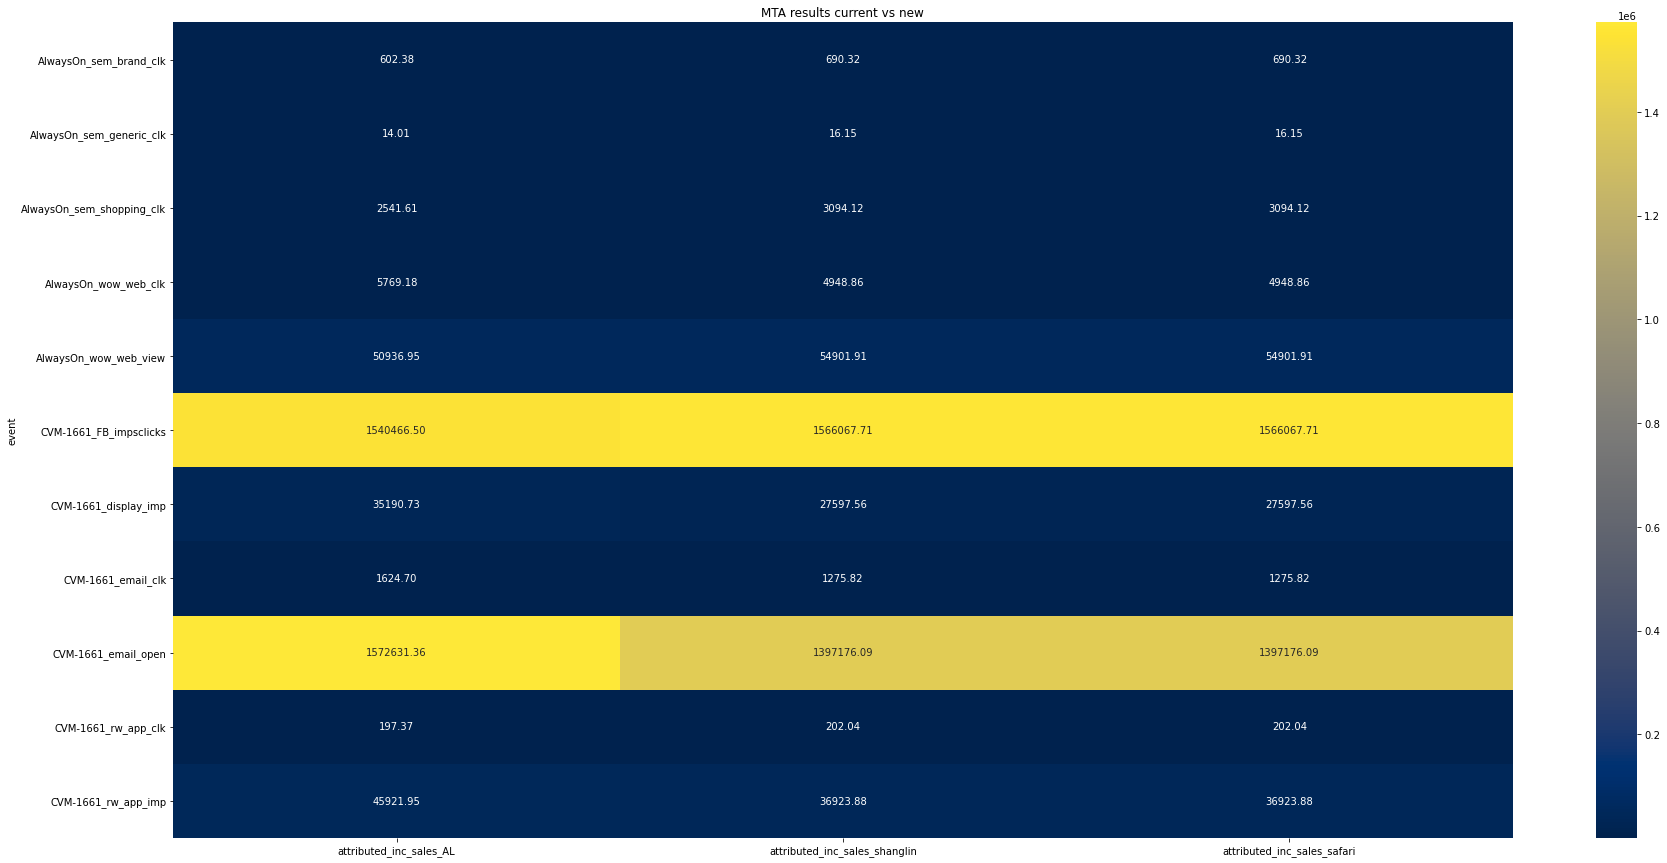

In [27]:
results = run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-02-22_2021-02-28_7.csv",
                                 BQ_output_suffix="_CVM-1661",
                                 campaign_code="CVM-1661",
                                 fw="2021-02-22",
                                 safari_run_date="2021-03-03",
                                 create_dacamp_prod_mc_final=True,
                                 have_historical_marketable_crn=False,
                                 use_xueyuans_mc_crn_output=True,
                                 allocate_fb=True,
                                 fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


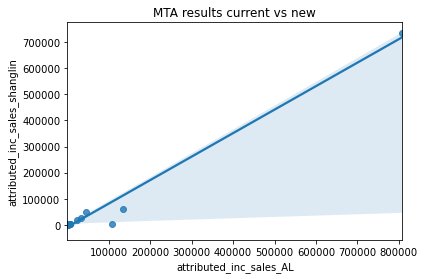

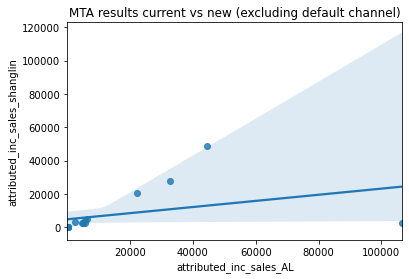

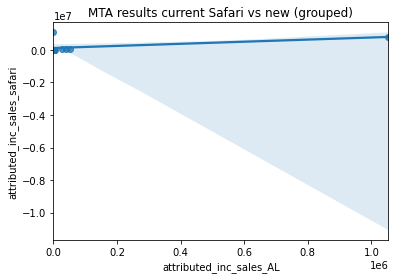

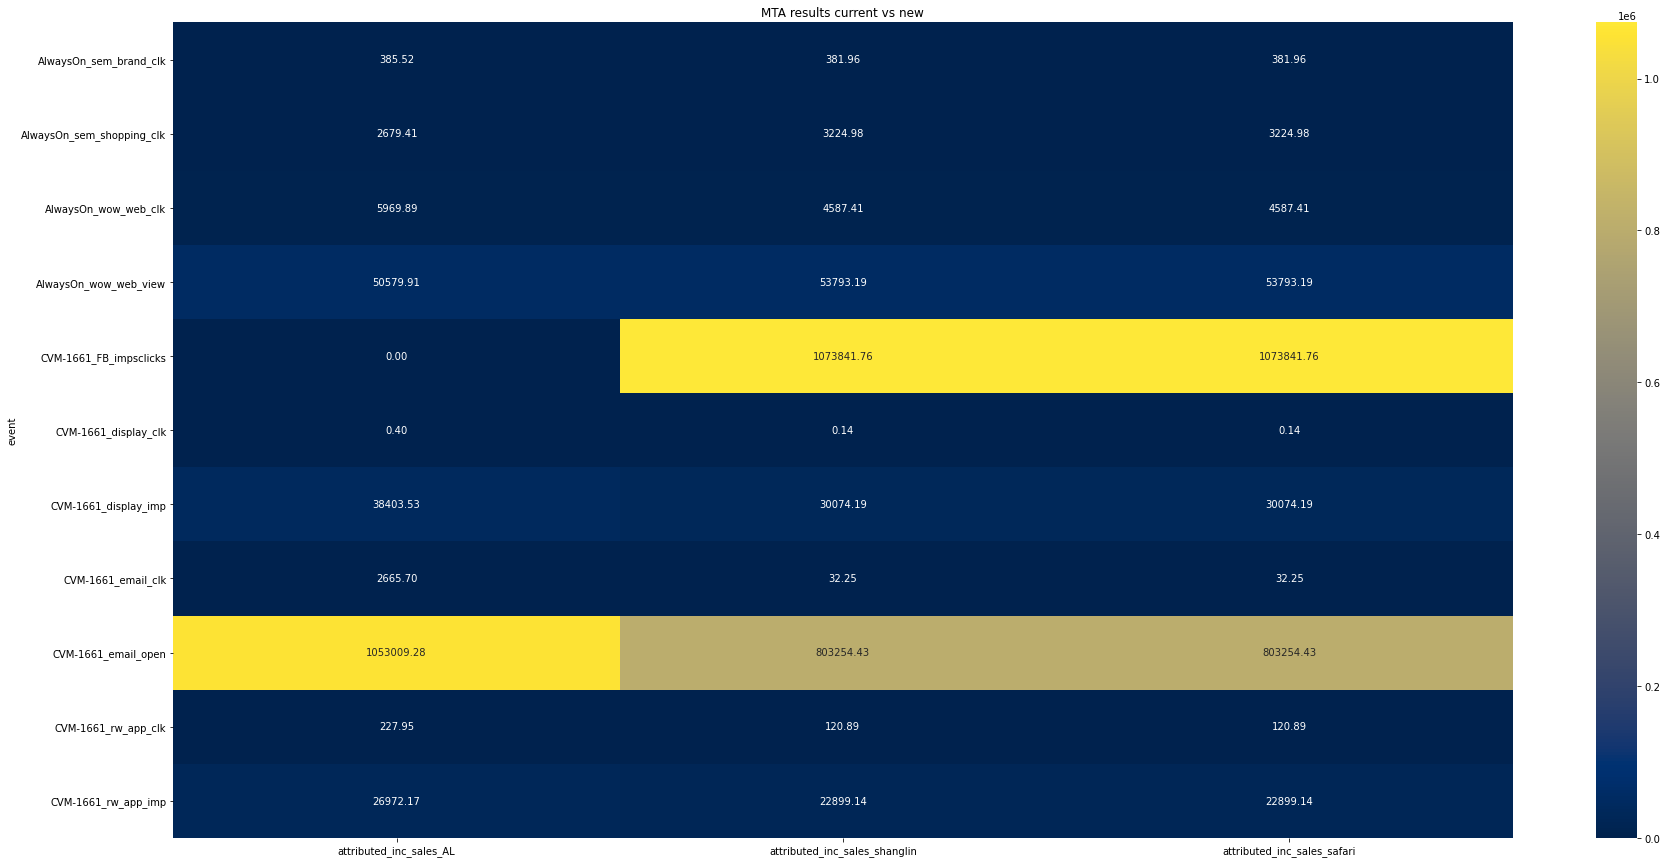

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-02-15 ... end of fw is 2021-02-21
	FB scaling ratio is (for missing slice of pie) 0.8969471969248284
	fb inc sales for CVM-1661 increased by 0.8969471974438341
	touchpoint count increased by 1237739


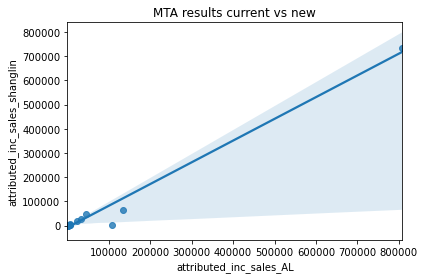

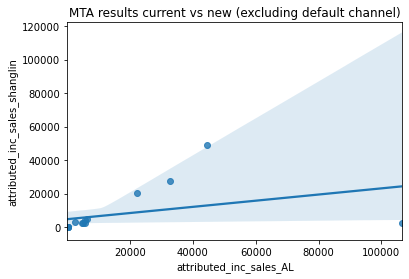

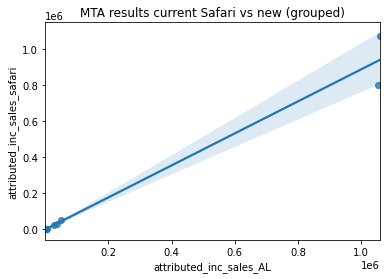

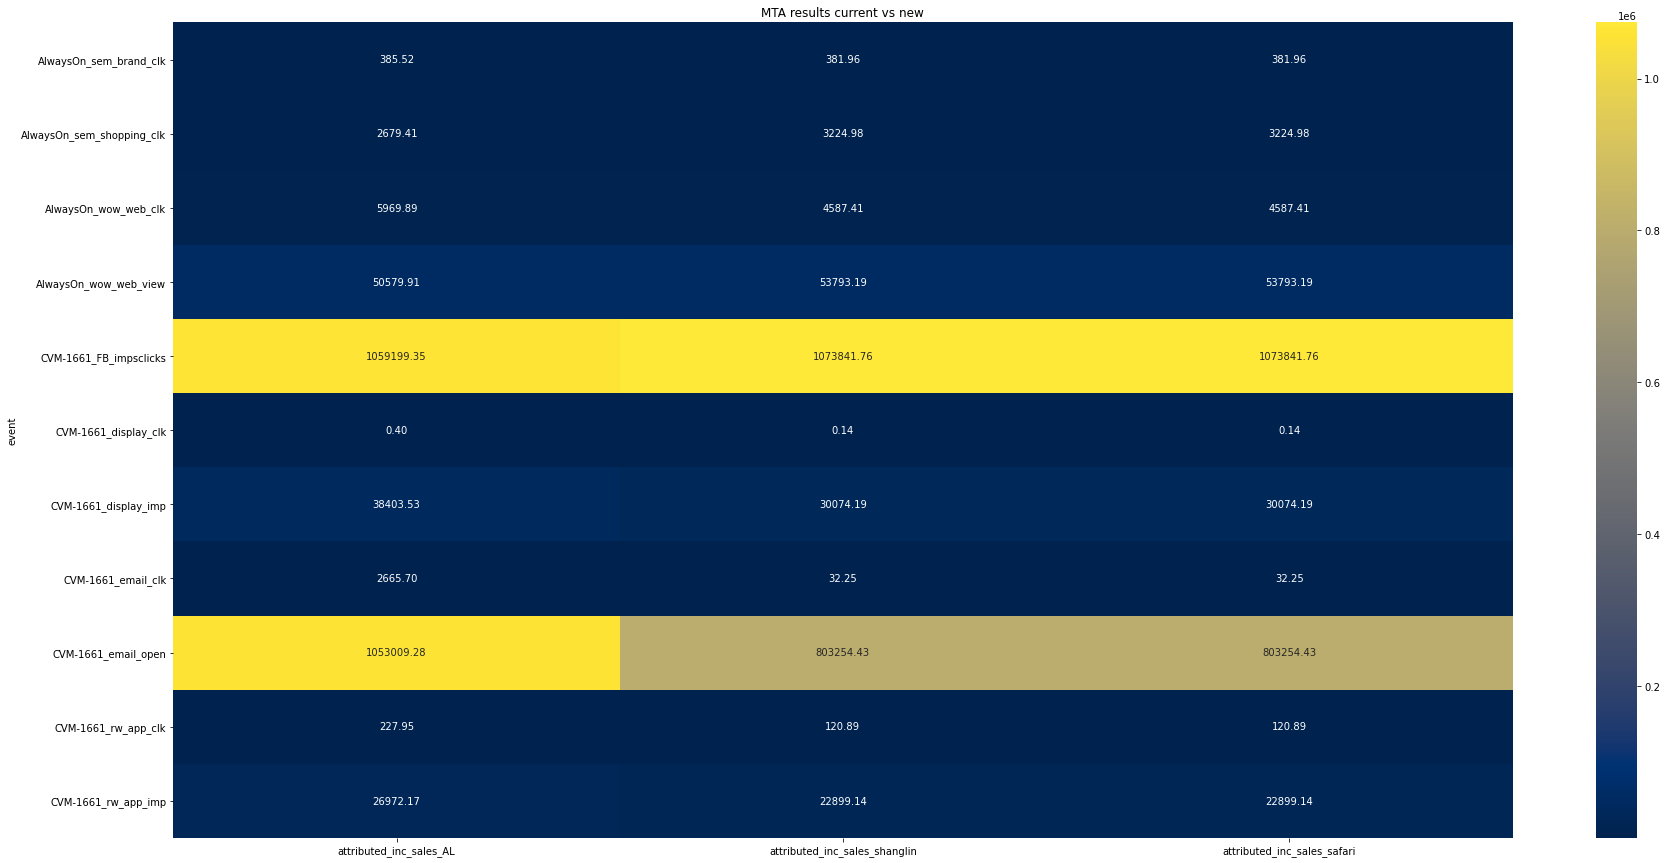

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.001081                    0.014222   
AlwaysOn_sem_shopping_clk              0.017867                    0.093369   
AlwaysOn_wow_web_clk                   0.081842                    0.295317   
AlwaysOn_wow_web_view                  0.180038                    0.844584   
CVM-1661_FB_impsclicks                -1.000000                    0.249040   
CVM-1661_display_clk                   0.000431                    0.001080   
CVM-1661_display_imp                   0.166242                    0.190876   
CVM-1661_email_clk                     0.074049                    0.039908   
CVM-1661_email_open                    0.344398                    0.286693   
CVM-1661_rw_app_clk                    0.010629                    0.013514   
CVM-1661_rw_app_imp                    0.123424                    0.220425   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                3.855161e+02   
AlwaysOn_sem_shopping_clk             2.679414e+03   
AlwaysOn_wow_web_clk                  5.969892e+03   
AlwaysOn_wow_web_view                 5.057991e+04   
CVM-1661_FB_impsclicks                1.059199e+06   
CVM-1661_display_clk                  3.967201e-01   
CVM-1661_display_imp                  3.840353e+04   
CVM-1661_email_clk                    2.665696e+03   
CVM-1661_email_open                   1.053009e+06   
CVM-1661_rw_app_clk                   2.279491e+02   
CVM-1661_rw_app_imp                   2.697217e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      3.819618e+02   
AlwaysOn_sem_shopping_clk                   3.224982e+03   
AlwaysOn_wow_web_clk                        4.587406e+03   
AlwaysOn_wow_web_view                       5.379319e+04   
CVM-1661_FB_impsclicks                      1.073842e+06   
CVM-1661_display_clk                        1.353774e-01   
CVM-1661_display_imp                        3.007419e+04   
CVM-1661_email_clk                          3.225007e+01   
CVM-1661_email_open                         8.032544e+05   
CVM-1661_rw_app_clk                         1.208911e+02   
CVM-1661_rw_app_imp                         2.289914e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    3.819618e+02  
AlwaysOn_sem_shopping_clk                 3.224982e+03  
AlwaysOn_wow_web_clk                      4.587406e+03  
AlwaysOn_wow_web_view                     5.379319e+04  
CVM-1661_FB_impsclicks                    1.073842e+06  
CVM-1661_display_clk                      1.353774e-01  
CVM-1661_display_imp                      3.007419e+04  
CVM-1661_email_clk                        3.225007e+01  
CVM-1661_email_open                       8.032544e+05  
CVM-1661_rw_app_clk                       1.208911e+02  
CVM-1661_rw_app_imp                       2.289914e+04

In [28]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-02-15_2021-02-21_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-02-15",
                       safari_run_date="2021-02-24",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       use_xueyuans_mc_crn_output=True,
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
>>> Step 3: Compare results to BAU run


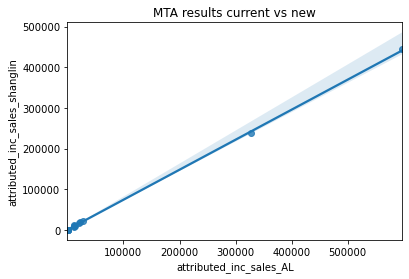

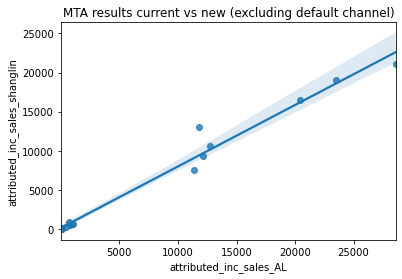

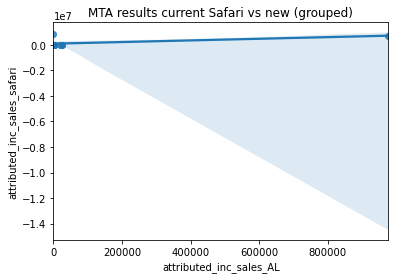

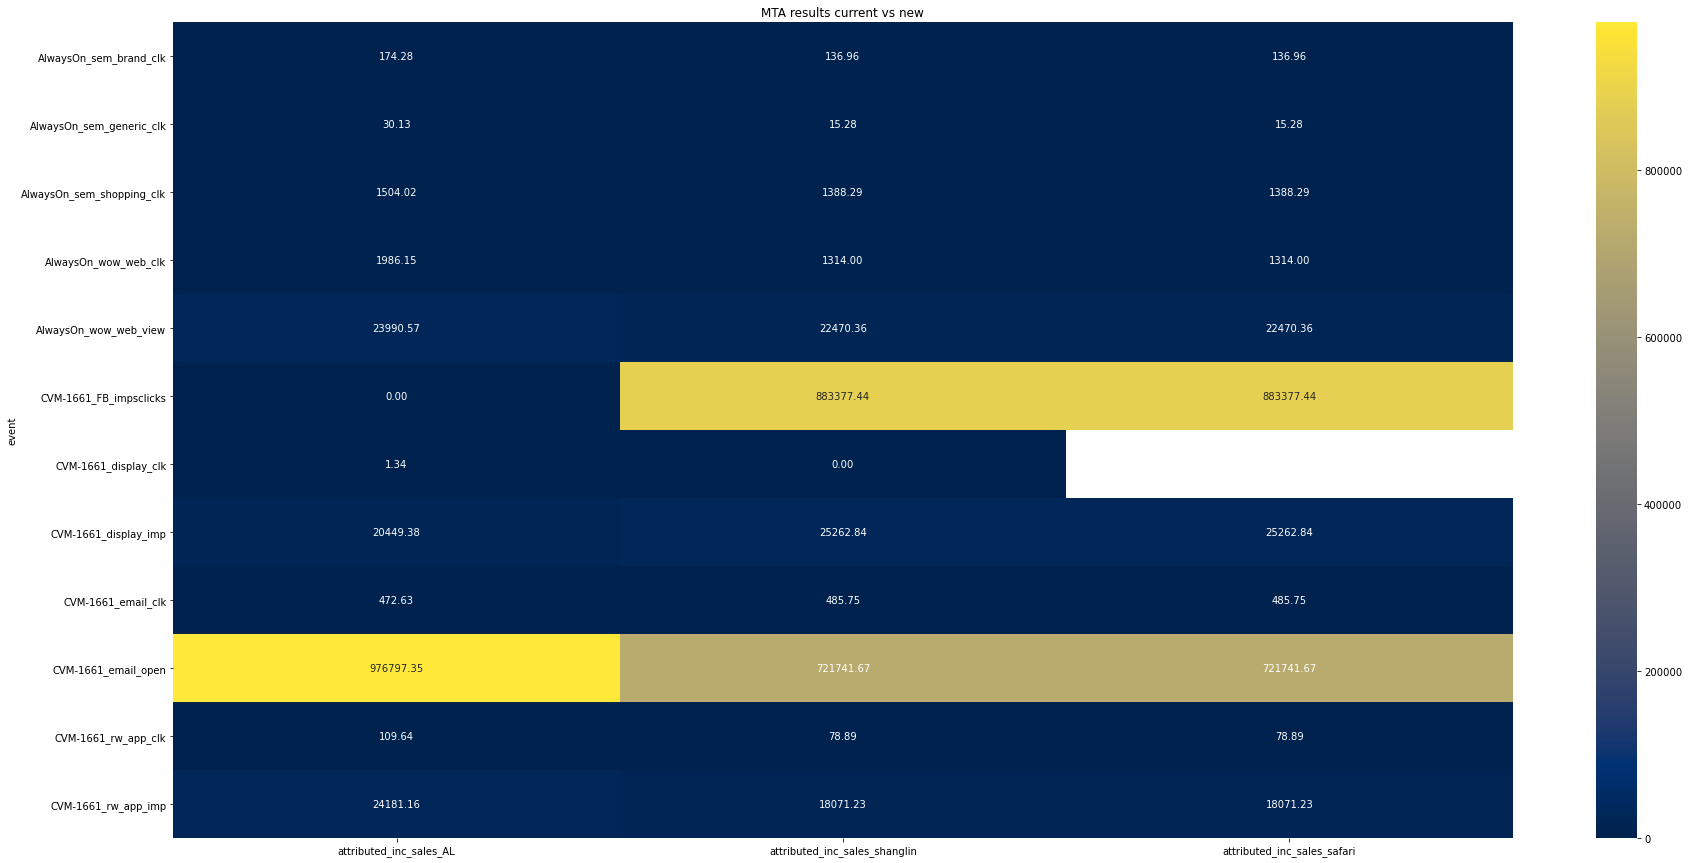

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-02-08 ... end of fw is 2021-02-14
	FB scaling ratio is (for missing slice of pie) 0.0
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for CVM-1661 increased by -3.083302407718471e-11
	touchpoint count increased by 1228242


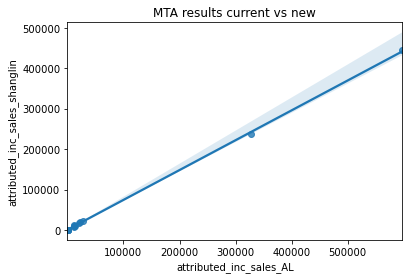

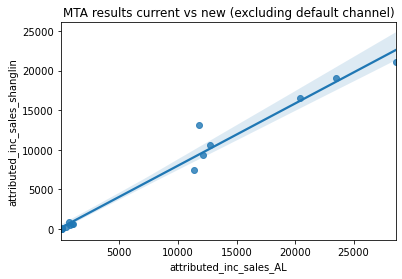

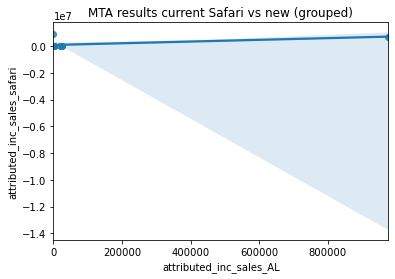

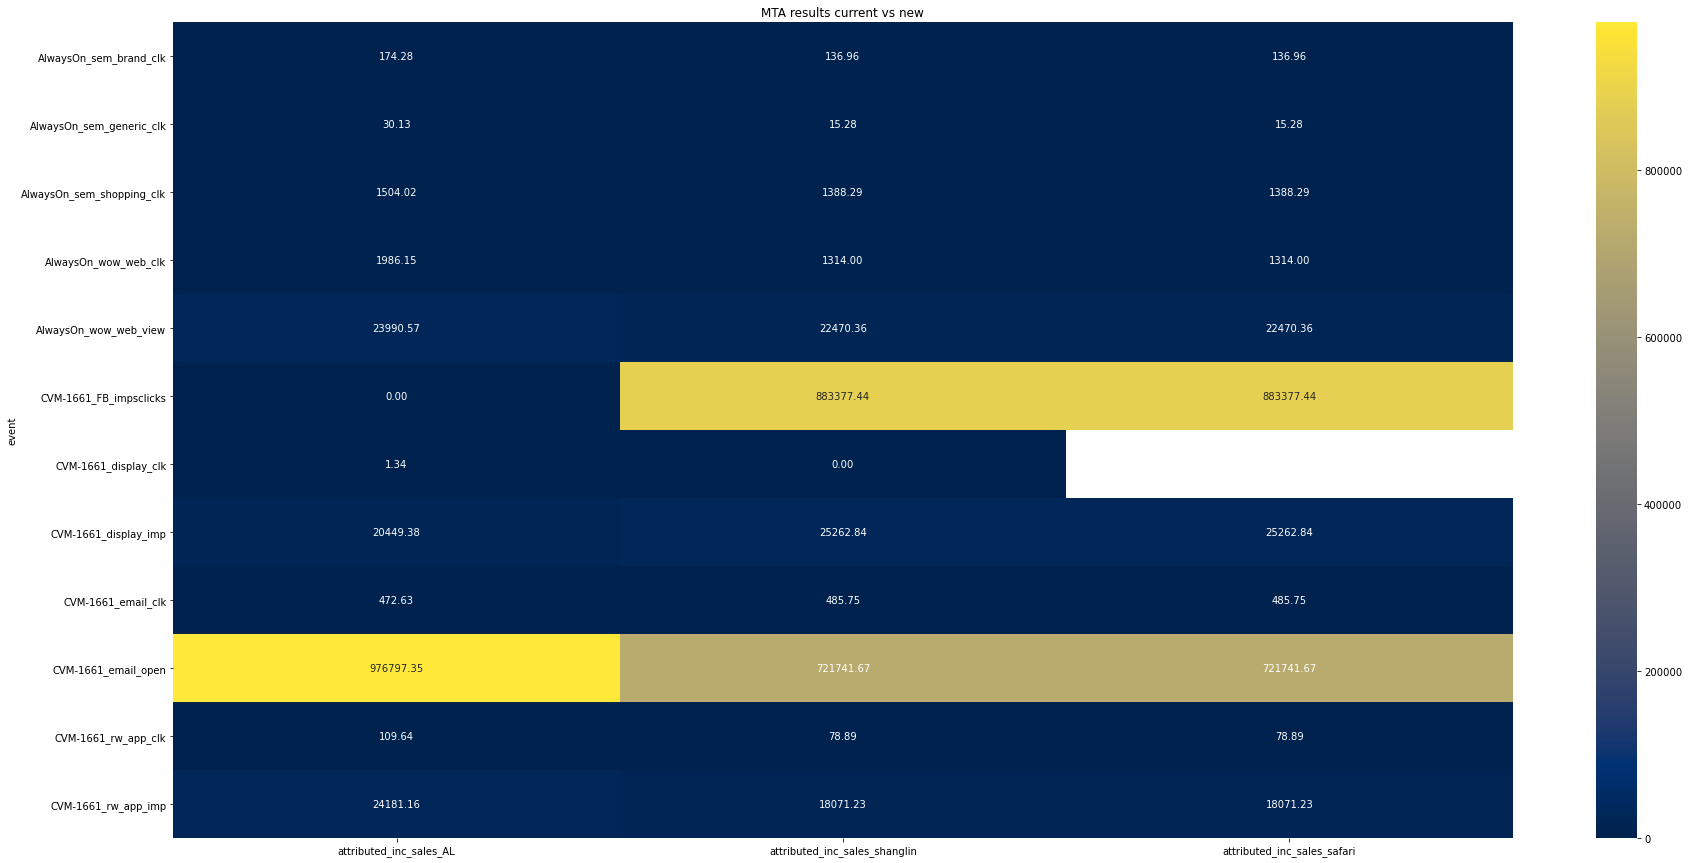

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.002852                    0.005793   
AlwaysOn_sem_generic_clk               0.000508                    0.001063   
AlwaysOn_sem_shopping_clk              0.027636                    0.064494   
AlwaysOn_wow_web_clk                   0.093567                    0.163571   
AlwaysOn_wow_web_view                  0.227991                    0.636296   
CVM-1661_FB_impsclicks                 0.000000                    0.413307   
CVM-1661_display_clk                   0.001263                    0.000000   
CVM-1661_display_imp                   0.186957                    0.139089   
CVM-1661_email_clk                     0.039522                    0.087528   
CVM-1661_email_open                    0.209028                    0.749495   
CVM-1661_rw_app_clk                    0.015501                    0.009667   
CVM-1661_rw_app_imp                    0.195175                    0.142992   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                  174.280335   
AlwaysOn_sem_generic_clk                 30.125340   
AlwaysOn_sem_shopping_clk              1504.021498   
AlwaysOn_wow_web_clk                   1986.150595   
AlwaysOn_wow_web_view                 23990.567189   
CVM-1661_FB_impsclicks                    0.000000   
CVM-1661_display_clk                      1.343845   
CVM-1661_display_imp                  20449.376567   
CVM-1661_email_clk                      472.633604   
CVM-1661_email_open                  976797.353016   
CVM-1661_rw_app_clk                     109.643901   
CVM-1661_rw_app_imp                   24181.155079   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                        136.961938   
AlwaysOn_sem_generic_clk                       15.278902   
AlwaysOn_sem_shopping_clk                    1388.291694   
AlwaysOn_wow_web_clk                         1313.995991   
AlwaysOn_wow_web_view                       22470.361063   
CVM-1661_FB_impsclicks                     883377.444253   
CVM-1661_display_clk                            0.000000   
CVM-1661_display_imp                        25262.844399   
CVM-1661_email_clk                            485.753834   
CVM-1661_email_open                        721741.669294   
CVM-1661_rw_app_clk                            78.886131   
CVM-1661_rw_app_imp                         18071.231999   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                      136.961938  
AlwaysOn_sem_generic_clk                     15.278902  
AlwaysOn_sem_shopping_clk                  1388.291694  
AlwaysOn_wow_web_clk                       1313.995991  
AlwaysOn_wow_web_view                     22470.361063  
CVM-1661_FB_impsclicks                   883377.444253  
CVM-1661_display_clk                               NaN  
CVM-1661_display_imp                      25262.844399  
CVM-1661_email_clk                          485.753834  
CVM-1661_email_open                      721741.669294  
CVM-1661_rw_app_clk                          78.886131  
CVM-1661_rw_app_imp                       18071.231999

In [30]:
run_downstream_process(fpath_results="01_results/res_weighted_CVM-1661_2021-02-08_2021-02-14_7.csv",
                       BQ_output_suffix="_CVM-1661",
                       campaign_code="CVM-1661",
                       fw="2021-02-08",
                       safari_run_date="2021-02-17",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       use_xueyuans_mc_crn_output=True,
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_weighted")